# EveryBeam MWA integration tests

Goes without saying, but the test here rely on `everybeam` being installed.

In [1]:
import sys
sys.path.append('/home/jline/software/installed/lib/python3.12/site-packages')
import os
from subprocess import call
from astropy.io import fits
import numpy as np
from astropy.table import Column, Table
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy import units as u
import matplotlib.pyplot as plt
import numpy.testing as npt
from astropy.constants import c
from astropy.wcs import WCS
import everybeam as eb
from wodenpy.primary_beam.use_everybeam import load_MWA_telescope, load_OSKAR_telescope, load_LOFAR_telescope, get_everybeam_norm, run_everybeam, radec_to_xyz
import erfa
import mwa_hyperbeam
from wodenpy.skymodel.read_fits_skymodel import calc_everybeam_for_components
from wodenpy.use_libwoden.create_woden_struct_classes import Woden_Struct_Classes
from ctypes import c_double
from astropy.time import TimeDelta
from wodenpy.use_libwoden.skymodel_structs import c_double_complex
from wodenpy.array_layout.precession import RTS_Precess_LST_Lat_to_J2000

##Create a woden struct class with double precision for the components
struct_classes = Woden_Struct_Classes(precision='double')

##A bunch of test and plotting code lives here so we can use it in multile notebooks
from eb_testing_code import create_WCS, plot_jones_on_sky, plot_everybeam_on_sky, make_sky_models, read_uvfits, convert_inst_to_stokes, test_stokes_recovery, getFDF, findpeaks, test_RM_recovery, make_RM_skymodel

C = c.to('m/s').value

ra0 = 0.0
dec0 = -26.7
MWA_LAT=-26.703319405555554

##pick a time/date that sticks our phase centre overhead
date = "2024-07-21T20:13:00"
##Assume that the OSKAR telescope is near the MWA??
mwa_location = EarthLocation(lat=MWA_LAT*u.deg, 
                            lon=116.67081523611111*u.deg,
                            height=377.827)
observing_time = Time(date, scale='utc', location=mwa_location)

##Grab the LST
LST = observing_time.sidereal_time('mean')
LST_deg = LST.value*15
print(f"LST: {LST_deg} deg, RA: {ra0}")


LST: 0.0045520088542088475 deg, RA: 0.0


Set up some observationals parameters. 

## What does the beam look like on the sky?

First up, let's plot the `hyperbeam` `MWA_FEE` beam model on the sky to see what we're expecting

/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:18110: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


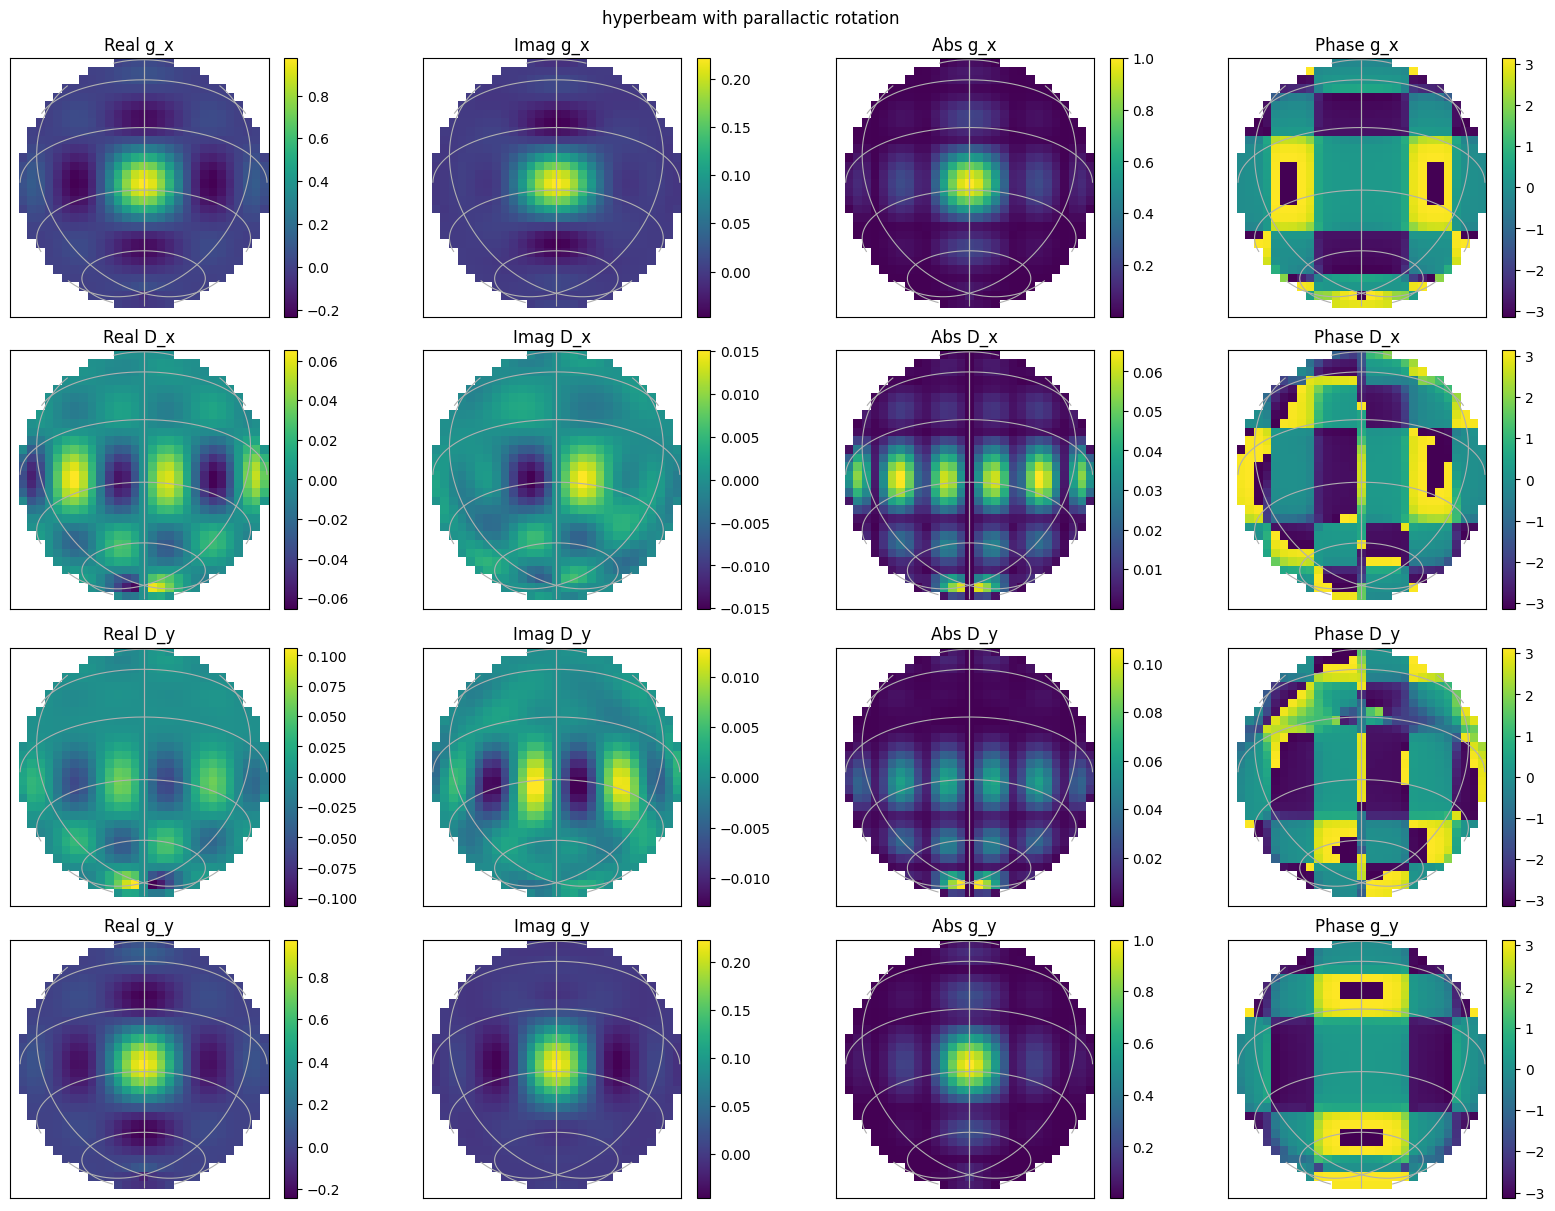

In [2]:
import os
os.environ["MWA_BEAM_FILE"] = "/home/jline/software/MWA_beam_files/mwa_full_embedded_element_pattern.h5"

nside=30
radec_reso=120/nside

header, wcs = create_WCS(ra0, dec0, nside, radec_reso)
x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))
ras, decs = wcs.all_pix2world(x_mesh, y_mesh, 0)

ras = ras.flatten()
decs = decs.flatten()

##Then use erfa to convert these values into azs, els
has = LST_deg - ras

##use this erfa function to convert to azimuth and elevation
##were using degrees, but erfa uses rads, so convert here
az_grid, els = erfa.hd2ae(np.radians(has), np.radians(decs), np.radians(MWA_LAT))

za_grid = np.pi/2 - els

beam = mwa_hyperbeam.FEEBeam()

freq = 180e+6

parallactic_rotation = True

jones = beam.calc_jones_array(az_grid, za_grid, freq, [0]*16, [1]*16, True, np.radians(MWA_LAT), parallactic_rotation)

all_gx = jones[:,0]
all_Dx = jones[:,1]
all_Dy = jones[:,2]
all_gy = jones[:,3]

all_gx.shape = (nside, nside)
all_Dx.shape = (nside, nside)
all_Dy.shape = (nside, nside)
all_gy.shape = (nside, nside)

plot_jones_on_sky(all_gx, all_Dx, all_Dy, all_gy, wcs, title="hyperbeam with parallactic rotation")

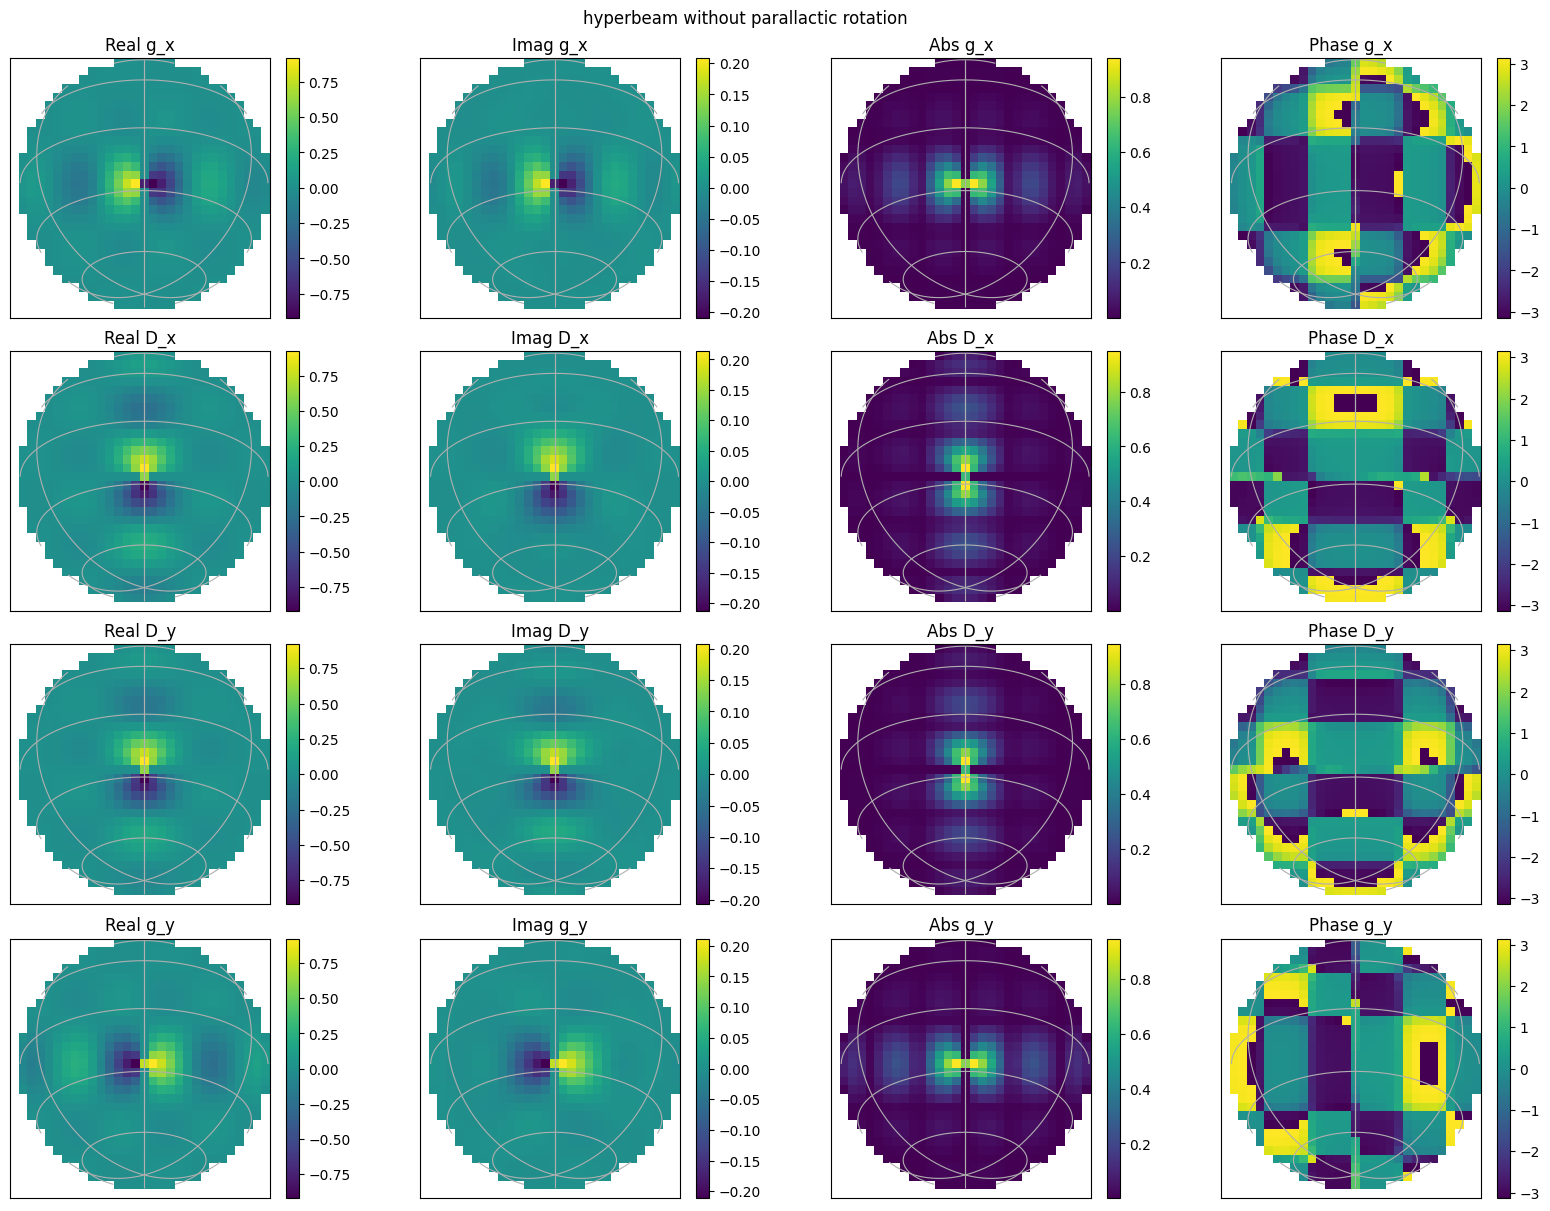

In [3]:
jones = beam.calc_jones_array(az_grid, za_grid, freq, [0]*16, [1]*16, True)

all_gx = jones[:,0]
all_Dx = jones[:,1]
all_Dy = jones[:,2]
all_gy = jones[:,3]

all_gx.shape = (nside, nside)
all_Dx.shape = (nside, nside)
all_Dy.shape = (nside, nside)
all_gy.shape = (nside, nside)

plot_jones_on_sky(all_gx, all_Dx, all_Dy, all_gy, wcs, title="hyperbeam without parallactic rotation")

## Parallactic rotation

As I understand it, the jones matrix that comes out WITHOUT parallactic angle correction is in a local telescope coordinate system, which is described by $\theta, \phi$. We have two dipoles, one aligned with east-west, the other north-south. I can write the instrument frame jones matrix as:

$$
J_{\mathrm{inst-frame}} =
\begin{bmatrix}
    j_{\mathrm{ew},\theta} & j_{\mathrm{ew},\phi} \\
    j_{\mathrm{ns},\theta} & j_{\mathrm{ns},\phi} \\
\end{bmatrix}
$$

what we want internally to `WODEN` is a jones matrix aligned to celestial coorindates, a.k.a RA,Dec. To do that, we need to rotate the response of each dipole by the parallactic angle $q$, via the rotation matrix:

$$
R_{q} =
\begin{bmatrix}
    \cos(q) & -\sin(q) \\
    \sin(q) & \cos(q) \\
\end{bmatrix}
$$

A celestial frame jones matrix could be written as:

$$
J_{\mathrm{inst-celeste}} =
\begin{bmatrix}
    j_{\mathrm{ew},\mathrm{RA}} & j_{\mathrm{ew},\mathrm{Dec}} \\
    j_{\mathrm{ns},\mathrm{RA}} & j_{\mathrm{ns},\mathrm{Dec}} \\
\end{bmatrix}
$$

which we get via:

$$
\begin{bmatrix}
    j_{\mathrm{ew},\mathrm{RA}} \\
    j_{\mathrm{ew},\mathrm{Dec}}
\end{bmatrix}
= R_{q}
\begin{bmatrix}
    j_{\mathrm{ew},\theta} \\
    j_{\mathrm{ew},\phi}
\end{bmatrix}
$$

$$
\begin{bmatrix}
    j_{\mathrm{ns},\mathrm{RA}} \\
    j_{\mathrm{ns},\mathrm{Dec}}
\end{bmatrix}
= R_{q}
\begin{bmatrix}
    j_{\mathrm{ns},\theta} \\
    j_{\mathrm{ns},\phi}
\end{bmatrix}
$$

Now, internally to the instrumental coords defined in the MWA beam code, I think the zero point for $\theta$ must point towards east, whereas the zero point for $q$ is aligned with north (??). So in practice (to get a correct looking answer) we have to rotate by $q - \pi/2$. Expanding the whole thing out, we get:

$$
\begin{align}
    j_{\mathrm{ew},\mathrm{RA}} &= j_{\mathrm{ew},\theta} \cos(q - \pi/2) - j_{\mathrm{ew},\phi} \sin(q - \pi/2) \\
    j_{\mathrm{ew},\mathrm{Dec}} &= j_{\mathrm{ew},\theta} \sin(q - \pi/2) + j_{\mathrm{ew},\phi} \cos(q - \pi/2) \\
    j_{\mathrm{ns},\mathrm{RA}} &= j_{\mathrm{ns},\theta} \cos(q - \pi/2) - j_{\mathrm{ns},\phi} \sin(q - \pi/2) \\
    j_{\mathrm{ns},\mathrm{Dec}} &= j_{\mathrm{ns},\theta} \sin(q - \pi/2) + j_{\mathrm{ns},\phi} \cos(q - \pi/2) \\
\end{align}
$$

Finally, internal to the `WODEN` code, we use the IAU definition of instrumental stokes, where XX = north-south, YY = east-west. So we rearrange the Jones to swap cardinals. We also add a minus sign to the RA components (because the MWA beam code is defined in a left-handed coordinate system, whereas the IAU is right-handed??). We have to add this sign flip to pass the Stokes recovery and rotation recovery tests that come later in this notebook. 

$$
J_{\mathrm{WODEN}} = 
\begin{bmatrix}
    j_{\mathrm{ns},\mathrm{Dec}} & -j_{\mathrm{ns},\mathrm{RA}} \\
    j_{\mathrm{ew},\mathrm{Dec}} & -j_{\mathrm{ew},\mathrm{RA}} \\
\end{bmatrix}
$$

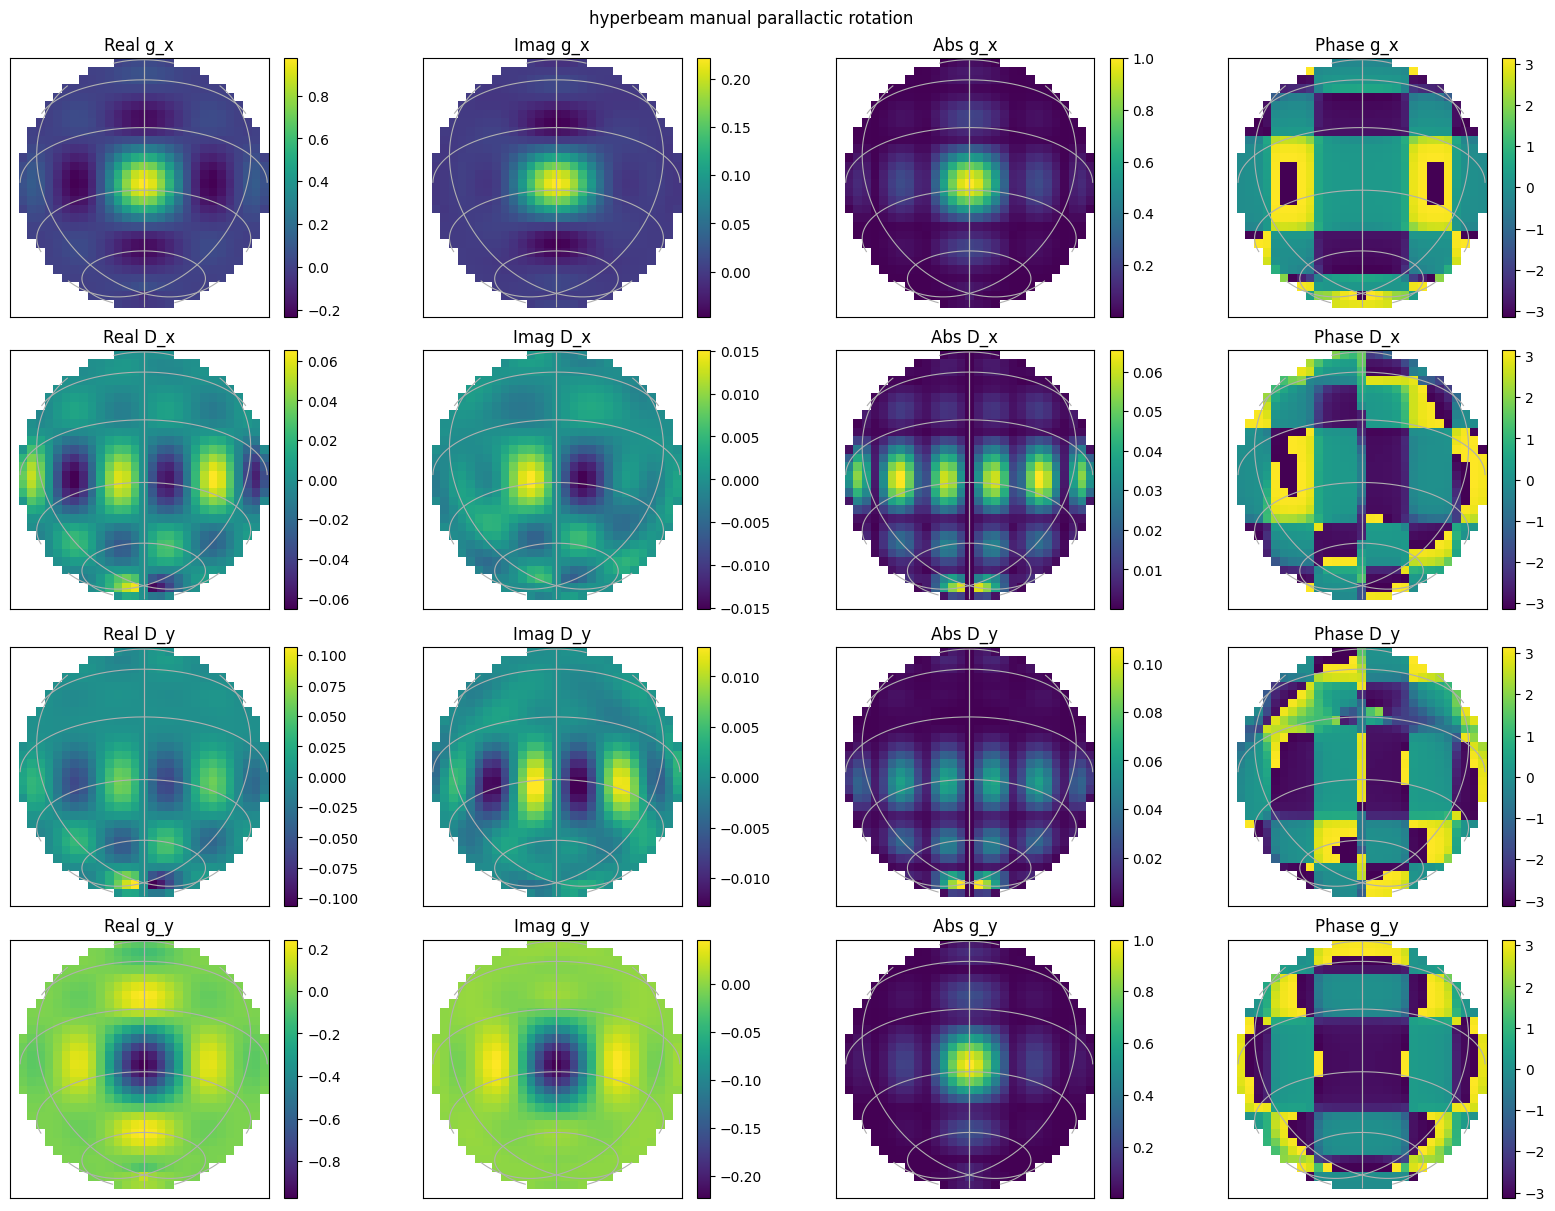

In [4]:
##DO THE MATHS TO PARA ROTATE THIS AND SEE WHAT IT LOOKS LIKE
all_gx = all_gx.flatten()
all_Dx = all_Dx.flatten()
all_Dy = all_Dy.flatten()
all_gy = all_gy.flatten()

rotate_gx = np.zeros_like(all_gx)
rotate_Dx = np.zeros_like(all_gx)
rotate_Dy = np.zeros_like(all_gx)
rotate_gy = np.zeros_like(all_gx)

for coord, ha, dec in zip(range(len(ras)), np.radians(has), np.radians(decs)):
    para_angle = erfa.hd2pa(ha, dec, np.radians(MWA_LAT))
    
    gx = all_gx[coord]
    Dx = all_Dx[coord]
    Dy = all_Dy[coord]
    gy = all_gy[coord]
    
    cospa = np.cos(para_angle - np.pi/2)
    sinpa = np.sin(para_angle - np.pi/2)
    
    rot_gx = cospa*gx + -sinpa*Dx
    rot_Dx = sinpa*gx + cospa*Dx
    rot_Dy = cospa*Dy + -sinpa*gy
    rot_gy = sinpa*Dy + cospa*gy
    
    rotate_gx[coord] = rot_gy
    rotate_Dx[coord] = rot_Dy
    rotate_Dy[coord] = rot_Dx
    rotate_gy[coord] = rot_gx
    
rotate_gx.shape = (nside, nside)
rotate_Dx.shape = (nside, nside)
rotate_Dy.shape = (nside, nside)
rotate_gy.shape = (nside, nside)
    
plot_jones_on_sky(rotate_gx, rotate_Dx, rotate_Dy, rotate_gy, wcs, title="hyperbeam manual parallactic rotation")


To check we have what we want, we look at the difference in power between the X and Y beams. What we want is an X beam from the N-S aligned dipoles. They are more sensitive in the E-W direction, so if we subtract the Y beam from the X beam, we should see a positives in the E-W direction, and negatives in the N-S.

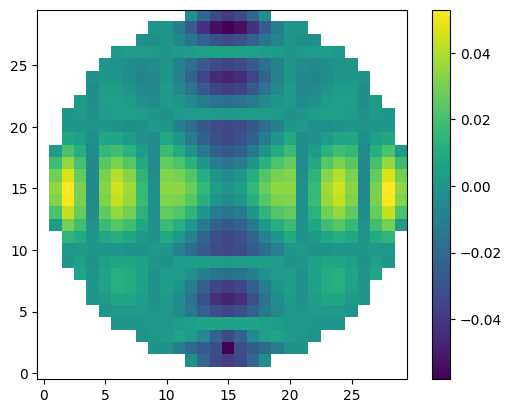

In [5]:
diff_gx = np.abs(rotate_gx) - np.abs(rotate_gy)
im = plt.imshow(diff_gx, origin='lower')
plt.colorbar(im)
plt.show()

Which is what we see, so hooray. Obviously this also matches the `hyperbeam` plot above, so we seem to be good.

## Using `everybeam`
Next, let's do the equivalent for the `everybeam` `MWA` beam model and see how it compares

2024-10-03 01:45:28	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4290)	Leap second table TAI_UTC seems out-of-date.
2024-10-03 01:45:28	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4290)+	Until the table is updated (see the CASA documentation or your system admin),
2024-10-03 01:45:28	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4290)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-10-03 01:45:28	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 387)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-10-03 01:45:28	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 387)+	/var/lib/casacore/data/ephemerides/
2024-10-03 01:45:28	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 387)+	/var/lib/casacore/data/geodetic/
2024-10-03 01:45:28	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

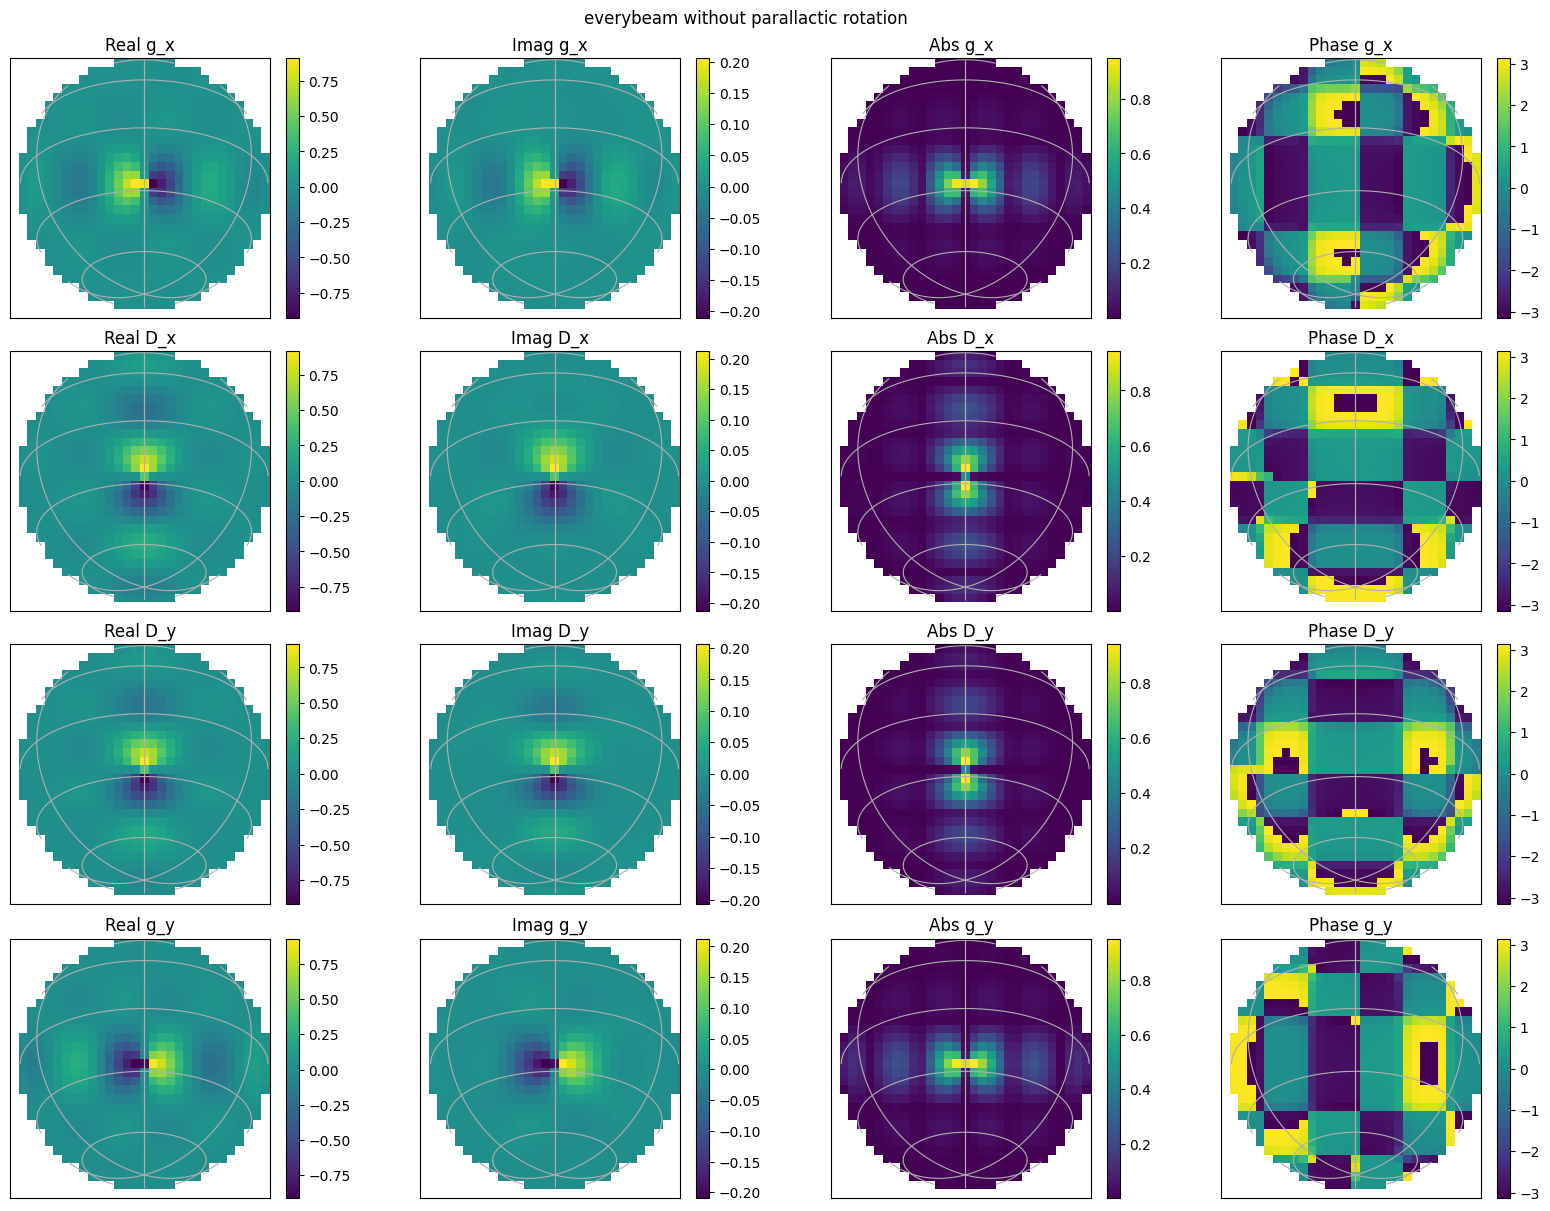

In [6]:
##I made the measurement set using OSKAR with the MWA layout
ms_path="MWA-single-timeslot.ms"
coeff_path="/home/jline/software/MWA_beam_files/mwa_full_embedded_element_pattern.h5"

telescope = eb.load_telescope(ms_path, use_differential_beam=True,
                                  coeff_path=coeff_path)
station_id = 0
    
all_gx = np.zeros(nside*nside, dtype=complex)
all_Dx = np.zeros(nside*nside, dtype=complex)
all_Dy = np.zeros(nside*nside, dtype=complex)
all_gy = np.zeros(nside*nside, dtype=complex)

ind = 0
for ra, dec in zip(ras, decs):
    
    jones = telescope.station_response(observing_time.mjd*3600*24, station_id, freq,
                                       np.radians(ra), np.radians(dec))
    
    all_gx[ind] = jones[0,0]
    all_Dx[ind] = jones[0,1]
    all_Dy[ind] = jones[1,0]
    all_gy[ind] = jones[1,1]
    
    ind += 1
    
all_gx.shape = (nside, nside)
all_Dx.shape = (nside, nside)
all_Dy.shape = (nside, nside)
all_gy.shape = (nside, nside)

plot_jones_on_sky(all_gx, all_Dx, all_Dy, all_gy, wcs, 'everybeam without parallactic rotation')

Now try and do a parallactic angle roatation. I can't get `everybeam` package to do the parallactic angle rotation I expect. Instead I've used the maths defined above and coded the rotation internal to `wodenpy`. To run it, means we need to use some of the `wodenpy` structures.

In [7]:
##Setup a grid of RA/Dec on the sky
# nside=30
# radec_reso = 120/nside

# header, wcs = create_WCS(ra0, dec0, nside, radec_reso)
# x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))
# ras, decs = wcs.all_pix2world(x_mesh, y_mesh, 0)

# ras = np.radians(ras.flatten())
# decs = np.radians(decs.flatten())

num_comps = len(ras)

##Create the components struct
components = struct_classes.Components()
##Allocate memory for the coords
components.ras = (c_double*num_comps)()
components.decs = (c_double*num_comps)()

##populate the coords
for ind, ra, dec in zip(range(num_comps), np.radians(ras), np.radians(decs)):
    components.ras[ind] = ra
    components.decs[ind] = dec


##Do a single freqs and time and beam
all_freqs = np.array([180e+6])
all_times = np.array([observing_time])
num_beams = 1
station_id = 0

lsts = []
latitudes = []

mjd = observing_time.mjd

for obs_time in all_times:
    
    LST = obs_time.sidereal_time('mean')
    lst_current = np.radians(LST.value*15)
    
    lst_J2000, latitude_J2000 = RTS_Precess_LST_Lat_to_J2000(
                                lst_current,
                                np.radians(MWA_LAT),
                                obs_time.mjd)
    
    lsts.append(lst_J2000)
    latitudes.append(latitude_J2000)

##allocate memory for the beam values

num_freqs = len(all_freqs)
num_times = len(all_times)

complex_num_beams = c_double_complex*(num_comps*num_beams*num_freqs*num_times)
        
components.gxs = complex_num_beams()
components.Dxs = complex_num_beams()
components.Dys = complex_num_beams()
components.gys = complex_num_beams()

calc_everybeam_for_components(np.radians(ra0), np.radians(station_id),
                              num_comps, components, telescope,
                              all_times, all_freqs,
                              station_id=station_id,
                              lsts=lsts, latitudes=latitudes,
                              parallactic_rotate=True)

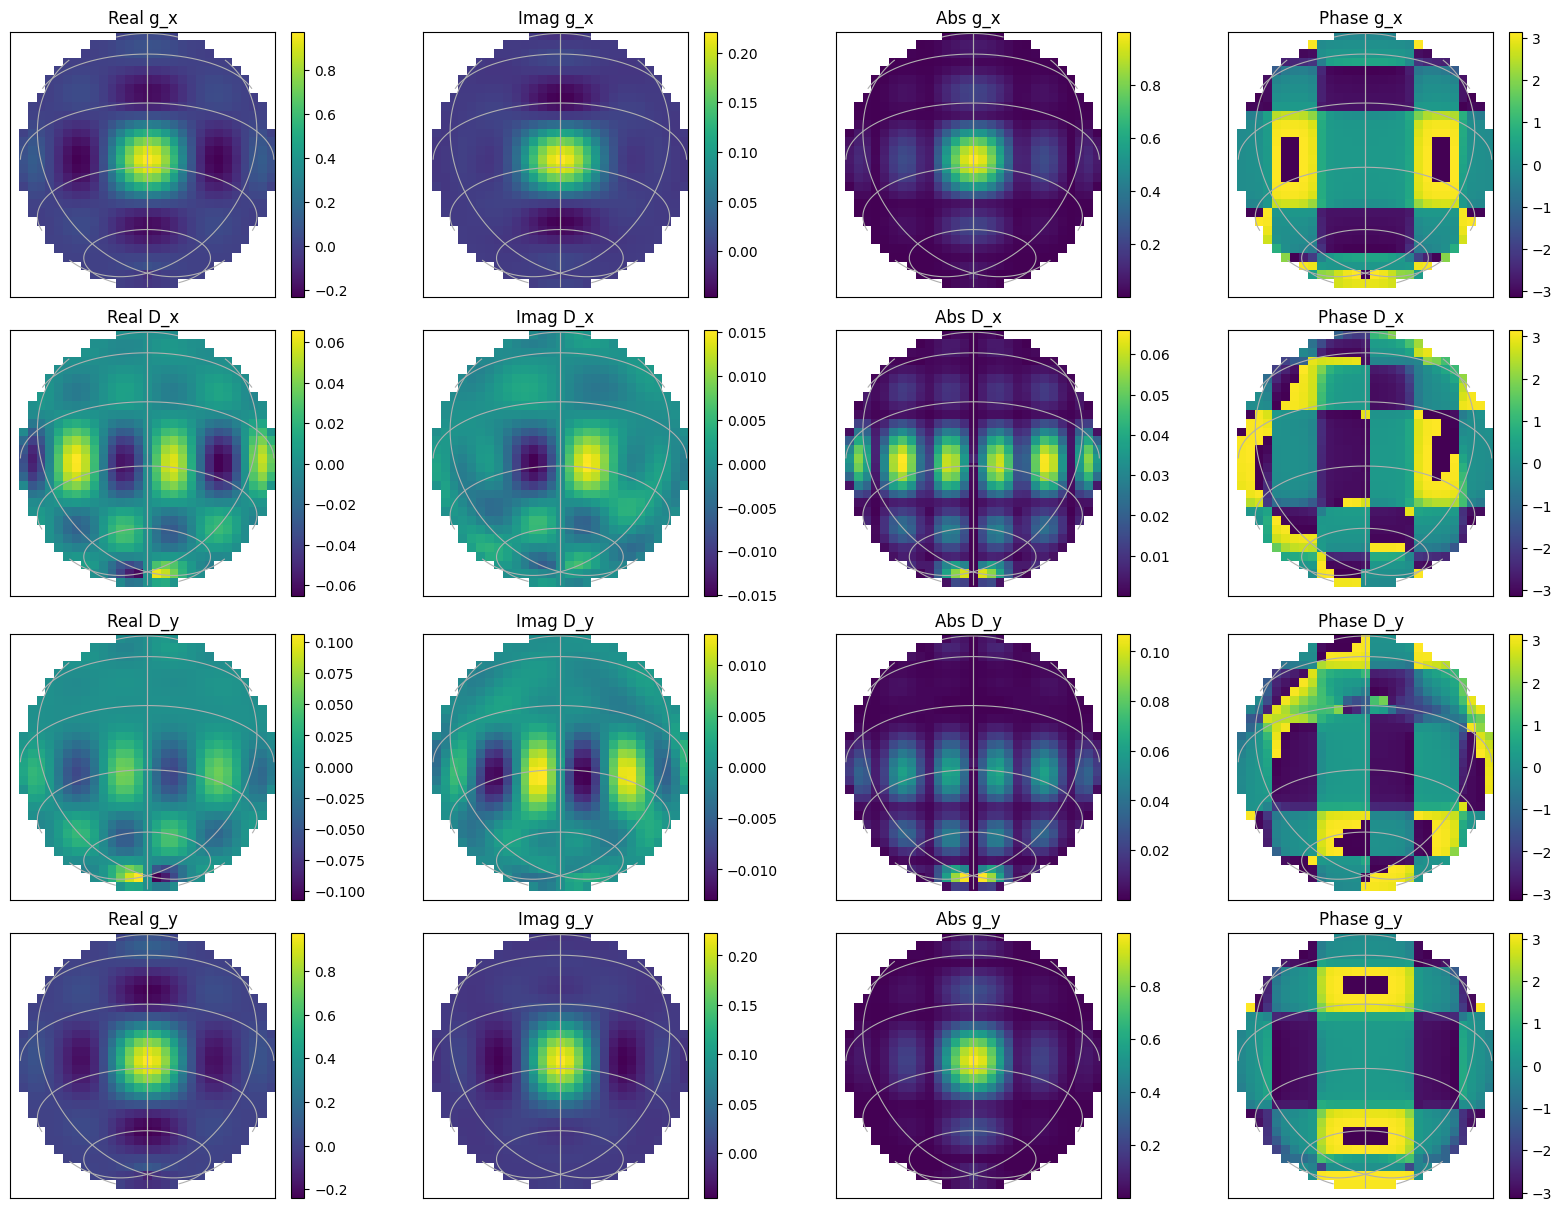

In [8]:
##grab the outputs, which should be ordered as primary beam slowest changing, time, freq, componnent fastest changing
##Do it over loops so we can get the real/imag parts out of the c_double_complex struct
all_gx = np.zeros((num_beams, num_times, num_freqs, num_comps), dtype=np.complex128)
all_Dx = np.zeros((num_beams, num_times, num_freqs, num_comps), dtype=np.complex128)
all_Dy = np.zeros((num_beams, num_times, num_freqs, num_comps), dtype=np.complex128)
all_gy = np.zeros((num_beams, num_times, num_freqs, num_comps), dtype=np.complex128)

for beam_ind in range(num_beams):
    for time_ind, time in enumerate(all_times):
        for freq_ind, freq in enumerate(all_freqs):
            for comp_ind in range(num_comps):
                ind = beam_ind*num_comps*num_freqs*num_times + time_ind*num_comps*num_freqs + freq_ind*num_comps + comp_ind
                # beam_ind*num_comps*num_freqs*num_times + time_ind*num_comps*num_freqs + freq_ind*num_comps + comp_ind
                
                all_gx[beam_ind, time_ind, freq_ind, comp_ind] = components.gxs[ind].real + 1j*components.gxs[ind].imag
                all_Dx[beam_ind, time_ind, freq_ind, comp_ind] = components.Dxs[ind].real + 1j*components.Dxs[ind].imag
                all_Dy[beam_ind, time_ind, freq_ind, comp_ind] = components.Dys[ind].real + 1j*components.Dys[ind].imag
                all_gy[beam_ind, time_ind, freq_ind, comp_ind] = components.gys[ind].real + 1j*components.gys[ind].imag

all_gx.shape = (nside, nside)
all_Dx.shape = (nside, nside)
all_Dy.shape = (nside, nside)
all_gy.shape = (nside, nside)

plot_jones_on_sky(all_gx, all_Dx, all_Dy, all_gy, wcs)

Soooo there are a couple of differences, especially in the phases of the leakage terms; but not too bad for now.

## Stokes IQUV recovery

Now test that we can recover Stokes IQUV from a point source.

Make our sky models. We'll make 4 Stokes I models, where each has either I, Q, U, V = 1, and all other Stokes are zero. To make that happen for Q/U, make the component a list type so explicitly set one or the other to zero.

In [9]:
make_sky_models(ra0, dec0)

Keep the simulations tiny by making a 3 ant array

In [10]:
np.random.seed(234987)

##make a random array layout. Source is at phase centre, so the visibilities
##should all be full real and just be set by the flux in the sky
num_antennas = 3
east = np.random.uniform(-1000, 1000, num_antennas)
north = np.random.uniform(-1000, 1000, num_antennas)
height = np.zeros(num_antennas)

array = np.empty((num_antennas, 3))
array[:,0] = east
array[:,1] = north
array[:,2] = height

array_name = "eg_array.txt"
np.savetxt(array_name, array)

Run the 4 different Stokes sky models through the MWA FEE beam. We're avoiding using metafits here to be as apples to apples with `EveryBeam` as possible.


In [11]:
##parameters for the simulation; setting the date sets an LST of about 0 deg
##to match the phase centre

import sys
sys.path.append('../../scripts/')
from run_woden import main as run_woden

freq_reso = 1e+6
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)

primary_beam = "MWA_FEE"

for pol in ['I', 'Q', 'U', 'V']:
    
    uvfits_name = f"stokes{pol}_{primary_beam}"
    cat_name = f'{pol}_source.fits'

    args = []

    args.append(f'--ra0={ra0}')
    args.append(f'--dec0={dec0}')
    args.append(f'--array_layout={array_name}')
    args.append(f'--date={date}')
    args.append(f'--output_uvfits_prepend={uvfits_name}')
    args.append(f'--primary_beam={primary_beam}')
    args.append(f'--freq_res={freq_reso}')
    args.append(f'--band_nums=1')
    args.append(f'--num_time_steps=1')
    args.append(f'--IAU_order')
    args.append(f'--cat_filename={cat_name}')
    args.append(f'--lowest_channel_freq={low_freq}')
    args.append(f'--num_freq_channels={num_freq_chans}')
    args.append(f'--time_res=2')
    args.append(f'--MWA_FEE_delays=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]')

    run_woden(args)

You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jline/software/WODEN_dev/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg -26.70000deg
Obs epoch initial LST was 0.0087300922 deg
Setting initial J2000 LST to 359.6931723607 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
Reading chunks 0:50 took 0.0 mins
WODEN is using DOUBLE precision
Simulating band 01 with bottom freq 1.80000000e+08
Middle freq is 1.80640000e+08 
HIP needs this printf otherwise it doesnt work
About to copy the chunked source to the GPU
Have copied across the

Tests are defined in `eb_testing_code.py`, which just asserts that whichever Stokes param we set to one comes out as one, and everything else is zero. Make the absolute tolerance of the test something to toggle, because real beam has leakage, and we don't have the beam at exactly the phase centre for `hyperbeam`. The Stokes recovery is only really legit when the XX and YY beams are the same, so it's good at phase centre and zenith.

Do the actual tests for MWA FEE beam

In [12]:

for pol in ['I', 'Q', 'U', 'V']:
    test_stokes_recovery(pol, 'MWA_FEE', atol=5e-3)


Testing Stokes I
Stokes I passed
Testing Stokes Q
Stokes Q passed
Testing Stokes U
Stokes U passed
Testing Stokes V
Stokes V passed


### Do it with "MWA" `everybeam`

Right, try and do the same thing with `OSKAR` "MWA" `everybeam`

In [13]:
##parameters for the simulation; setting the date sets an LST of about 0 deg
##to match the phase centre

freq_reso = 1e+6
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)

primary_beam = "everybeam_MWA"

# print("WHAT DIS", os.environ["MWA_FEE_HDF5"])

for pol in ['I', 'Q', 'U', 'V']:

    uvfits_name = f"stokes{pol}_{primary_beam}"
    cat_name = f'{pol}_source.fits'
    
    args = []

    args.append(f'--ra0={ra0}')
    args.append(f'--dec0={dec0}')
    args.append(f'--array_layout={array_name}')
    args.append(f'--date={date}')
    args.append(f'--output_uvfits_prepend={uvfits_name}')
    args.append(f'--primary_beam={primary_beam}')
    args.append(f'--beam_ms_path={ms_path}')
    args.append(f'--freq_res={freq_reso}')
    args.append(f'--band_nums=1')
    args.append(f'--num_time_steps=1')
    args.append(f'--IAU_order')
    args.append(f'--station_id=0')
    args.append(f'--cat_filename={cat_name}')
    args.append(f'--lowest_channel_freq={low_freq}')
    args.append(f'--num_freq_channels={num_freq_chans}')
    args.append(f'--time_res=2')

    run_woden(args)

You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jline/software/WODEN_dev/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg -26.70000deg
Obs epoch initial LST was 0.0087300922 deg
Setting initial J2000 LST to 359.6931723607 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
Reading chunks 0:50 took 0.0 mins
WODEN is using DOUBLE precision
Simulating band 01 with bottom freq 1.80000000e+08
About to copy the chunked source to the GPU
Have copied across the chunk to the GPU
Processing chunk 0
	Number of components in chunk are: P 1 G

In [14]:
for pol in ['I', 'Q', 'U', 'V']:
    test_stokes_recovery(pol, 'everybeam_MWA', atol=9e-2)
    
    ##Uncomment to print out example values
    
    # uvfits_name = f"stokes{pol}_everybeam_MWA"
    # XX, XY, YX, YY = read_uvfits(f'{uvfits_name}_band01.uvfits')
    # ##pick a random baseline to plot, they should all be the sam
    # baseline = 0

    # recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline])
    
    # print(f"{pol}, {recover_I[0].real:.2f}, {recover_Q[0].real:.2f}, {recover_U[0].real:.2f}, {recover_V[0].real:.2f}")

Testing Stokes I
Stokes I passed
Testing Stokes Q
Stokes Q passed
Testing Stokes U
Stokes U passed
Testing Stokes V
Stokes V passed


## Now test an RM recovery
Check we recover the correct RM and sign for a linearly polarised source. First of all, make the sky model.

In [15]:
phi_RM, pol_frac = make_RM_skymodel(ra0, dec0)

Run that through WODEN.

In [16]:
freq_reso = 0.1e+6
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)


primary_beam = "MWA_FEE"

uvfits_name = f"rm_source_{primary_beam}"
cat_name = 'RM_source.fits'

args = []

args.append(f'--ra0={ra0}')
args.append(f'--dec0={dec0}')
args.append(f'--array_layout={array_name}')
args.append(f'--date={date}')
args.append(f'--output_uvfits_prepend={uvfits_name}')
args.append(f'--primary_beam={primary_beam}')
args.append(f'--freq_res={freq_reso}')
args.append(f'--band_nums=1')
args.append(f'--num_time_steps=1')
args.append(f'--IAU_order')
args.append(f'--MWA_FEE_delays=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]')
args.append(f'--cat_filename={cat_name}')
args.append(f'--lowest_channel_freq={low_freq}')
args.append(f'--num_freq_channels={num_freq_chans}')
args.append(f'--time_res=2')

run_woden(args)

You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jline/software/WODEN_dev/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg -26.70000deg
Obs epoch initial LST was 0.0087300922 deg
Setting initial J2000 LST to 359.6931723607 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
Reading chunks 0:50 took 0.0 mins
WODEN is using DOUBLE precision
Simulating band 01 with bottom freq 1.80000000e+08
Middle freq is 1.80640000e+08 
HIP needs this printf otherwise it doesnt work
About to copy the chunked source to the GPU
Have copied across the

Have a look and check our visis make sense

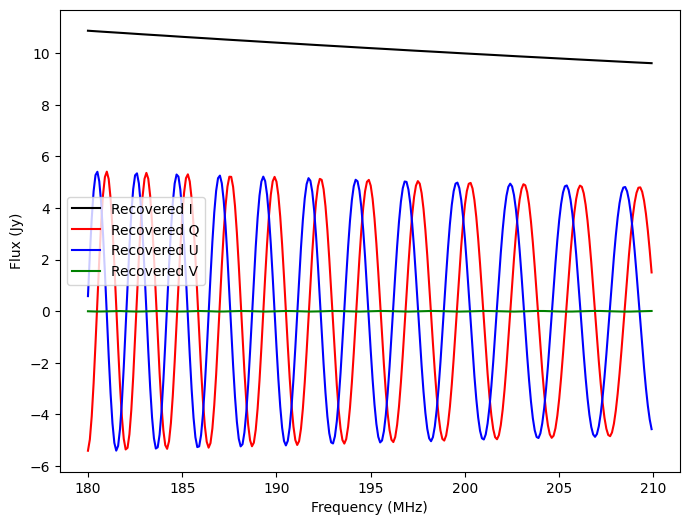

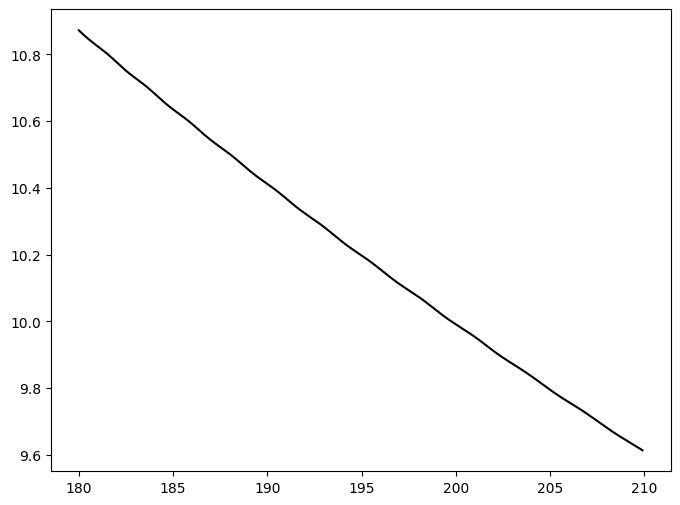

In [17]:
XX, XY, YX, YY = read_uvfits('rm_source_MWA_FEE_band01.uvfits')
baseline = 0    
recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline])

    
freqs = np.arange(low_freq, high_freq, freq_reso)

fig, axs = plt.subplots(1, 1, figsize=(8, 6))

axs.plot(freqs / 1e+6, recover_I.real, 'k-', label='Recovered I')
axs.plot(freqs / 1e+6, recover_Q.real, 'r', label='Recovered Q')
axs.plot(freqs / 1e+6, recover_U.real, 'b', label='Recovered U')
axs.plot(freqs / 1e+6, recover_V.real, 'g', label='Recovered V')

axs.legend()

axs.set_xlabel('Frequency (MHz)')
axs.set_ylabel('Flux (Jy)')

plt.show()

# fig, axs = plt.subplots(1, 1, figsize=(8, 6))
# axs.plot(freqs / 1e+6, recover_I.real, 'k-', label='Polarisation Fraction')

Now define a test, using a bunch of Emil's RM synthesis code. 

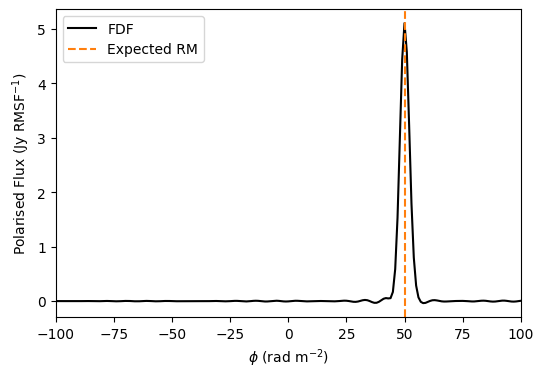

Recovered RM: 50.0 Expected RM: 50
Recovered Pol. Fraction: 0.49999532 Expected Pol Fraction 0.5


In [18]:
test_RM_recovery(uvfits_name, phi_RM, pol_frac, freqs)

### Do it with `everybeam`

In [19]:
freq_reso = 0.1e+6
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)

primary_beam = "everybeam_MWA"
uvfits_name = f"rm_source_{primary_beam}"
cat_name = 'RM_source.fits'

args = []

args.append(f'--ra0={ra0}')
args.append(f'--dec0={dec0}')
args.append(f'--array_layout={array_name}')
args.append(f'--date={date}')
args.append(f'--output_uvfits_prepend={uvfits_name}')
args.append(f'--primary_beam={primary_beam}')
args.append(f'--beam_ms_path={ms_path}')
args.append(f'--freq_res={freq_reso}')
args.append(f'--band_nums=1')
args.append(f'--num_time_steps=1')
args.append(f'--IAU_order')
args.append(f'--station_id=0')
args.append(f'--cat_filename={cat_name}')
args.append(f'--lowest_channel_freq={low_freq}')
args.append(f'--num_freq_channels={num_freq_chans}')
args.append(f'--time_res=2')

run_woden(args)


You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jline/software/WODEN_dev/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg -26.70000deg
Obs epoch initial LST was 0.0087300922 deg
Setting initial J2000 LST to 359.6931723607 deg
Setting initial mjd to 60512.8423726853
After precession initial latitude of the array is -26.8398178265 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
Reading chunks 0:50 took 0.4 mins
WODEN is using DOUBLE precision
Simulating band 01 with bottom freq 1.80000000e+08
About to copy the chunked source to the GPU
Have copied across the chunk to the GPU
Processing chunk 0
	Number of components in chunk are: P 1 G

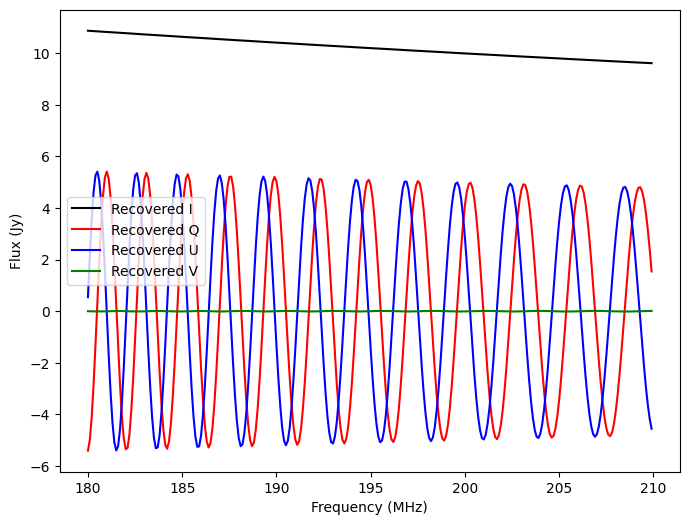

In [20]:
XX, XY, YX, YY = read_uvfits('rm_source_everybeam_MWA_band01.uvfits')
baseline = 0    
recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline])

    
freqs = np.arange(low_freq, high_freq, freq_reso)

fig, axs = plt.subplots(1, 1, figsize=(8, 6))

axs.plot(freqs / 1e+6, recover_I.real, 'k-', label='Recovered I')
axs.plot(freqs / 1e+6, recover_Q.real, 'r', label='Recovered Q')
axs.plot(freqs / 1e+6, recover_U.real, 'b', label='Recovered U')
axs.plot(freqs / 1e+6, recover_V.real, 'g', label='Recovered V')

axs.legend()

axs.set_xlabel('Frequency (MHz)')
axs.set_ylabel('Flux (Jy)')

plt.show()

Looks good!

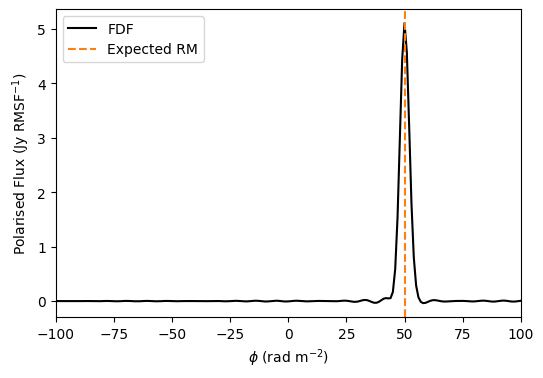

Recovered RM: 50.0 Expected RM: 50
Recovered Pol. Fraction: 0.49999523 Expected Pol Fraction 0.5


In [21]:
test_RM_recovery(uvfits_name, phi_RM, pol_frac, freqs)

Yup works woot

## Test antenna locations

<!-- Now check to see if the antenna locations are read in correctly from a measurement set. We'll run `WODEN` using the `metafits` file that was used to make the `OSKAR MWA` measurement set. Then compare that to running the with the same settings but using the `OSKAR MWA` measurement set directly.  -->

In [22]:
phi_RM, pol_frac = make_RM_skymodel(ra0, dec0)
ra0 = 60.0
date = "2015-09-10T19:44:15"

freq_reso = 0.1e+6
low_freq = 180e+6
num_freq_chans = 1

primary_beam = "MWA_FEE"

uvfits_name = f"ant_locs_{primary_beam}"
cat_name = 'RM_source.fits'

args = []

args.append(f'--ra0={ra0}')
args.append(f'--dec0={dec0}')
args.append(f'--date={date}')
args.append(f'--output_uvfits_prepend={uvfits_name}')
args.append(f'--metafits_filename=../../examples/metafits/1125949472_metafits.fits')
args.append(f'--primary_beam={primary_beam}')
args.append(f'--freq_res={freq_reso}')
args.append(f'--band_nums=1')
args.append(f'--num_time_steps=1')
args.append(f'--IAU_order')
args.append(f'--cat_filename={cat_name}')
args.append(f'--lowest_channel_freq={low_freq}')
args.append(f'--num_freq_channels={num_freq_chans}')
args.append(f'--time_res=2')
args.append(f'--MWA_FEE_delays=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]')

run_woden(args)

You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jline/software/WODEN_dev/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 60.00000deg -26.70000deg
Obs epoch initial LST was 42.2620215148 deg
Setting initial J2000 LST to 42.0911874758 deg
Setting initial mjd to 57275.8224074073
After precession initial latitude of the array is -26.7665041369 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
Reading chunks 0:50 took 0.0 mins
WODEN is using DOUBLE precision
Simulating band 01 with bottom freq 1.80000000e+08
Middle freq is 1.80640000e+08 
HIP needs this printf otherwise it doesnt work
About to copy the chunked source to the GPU
Have copied across th

In [23]:
primary_beam = "everybeam_MWA"

uvfits_name = f"ant_locs_{primary_beam}"
cat_name = 'RM_source.fits'

ms_path = '/mnt/c/Users/jackl/Dropbox/work/test_WODEN/everybeam/run_MWA_beam/hypcal_1125949472.ms'


args = []

args.append(f'--ra0={ra0}')
args.append(f'--dec0={dec0}')
args.append(f'--date={date}')
args.append(f'--output_uvfits_prepend={uvfits_name}')
args.append(f'--primary_beam={primary_beam}')
args.append(f'--beam_ms_path={ms_path}')
args.append(f'--freq_res={freq_reso}')
args.append(f'--band_nums=1')
args.append(f'--num_time_steps=1')
args.append(f'--IAU_order')
args.append(f'--station_id=0')
args.append(f'--cat_filename={cat_name}')
args.append(f'--lowest_channel_freq={low_freq}')
args.append(f'--num_freq_channels={num_freq_chans}')
args.append(f'--time_res=2')

run_woden(args)

Successful readonly open of default-locked table /mnt/c/Users/jackl/Dropbox/work/test_WODEN/everybeam/run_MWA_beam/hypcal_1125949472.ms/ANTENNA: 13 columns, 128 rows
You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jline/software/WODEN_dev/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 60.00000deg -26.70000deg
Obs epoch initial LST was 42.2620215148 deg
Setting initial J2000 LST to 42.0911874758 deg
Setting initial mjd to 57275.8224074073
After precession initial latitude of the array is -26.7665041369 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
Reading chunks 0:50 took 0.0 mins
WODEN is using DOUBLE precision
Simulating band 01 with bott

Read in the XYZ positions from the resultant `uvfits` files, as well as the `uvw` coordinates.

In [24]:
def read_xyz_uvfits(uvfits_name):
    
    with fits.open(uvfits_name) as hdu:
        xyz = hdu[1].data['STABXYZ']
        uu = hdu[0].data['UU']*C
        vv = hdu[0].data['VV']*C
        ww = hdu[0].data['WW']*C
        
    return xyz, uu, vv, ww


In [25]:
xyz_meta, uu_meta, vv_meta, ww_meta = read_xyz_uvfits('ant_locs_MWA_FEE_band01.uvfits')
xyz_ms, uu_ms, vv_ms, ww_ms = read_xyz_uvfits('ant_locs_everybeam_MWA_band01.uvfits')

First up compare the XYZ coords

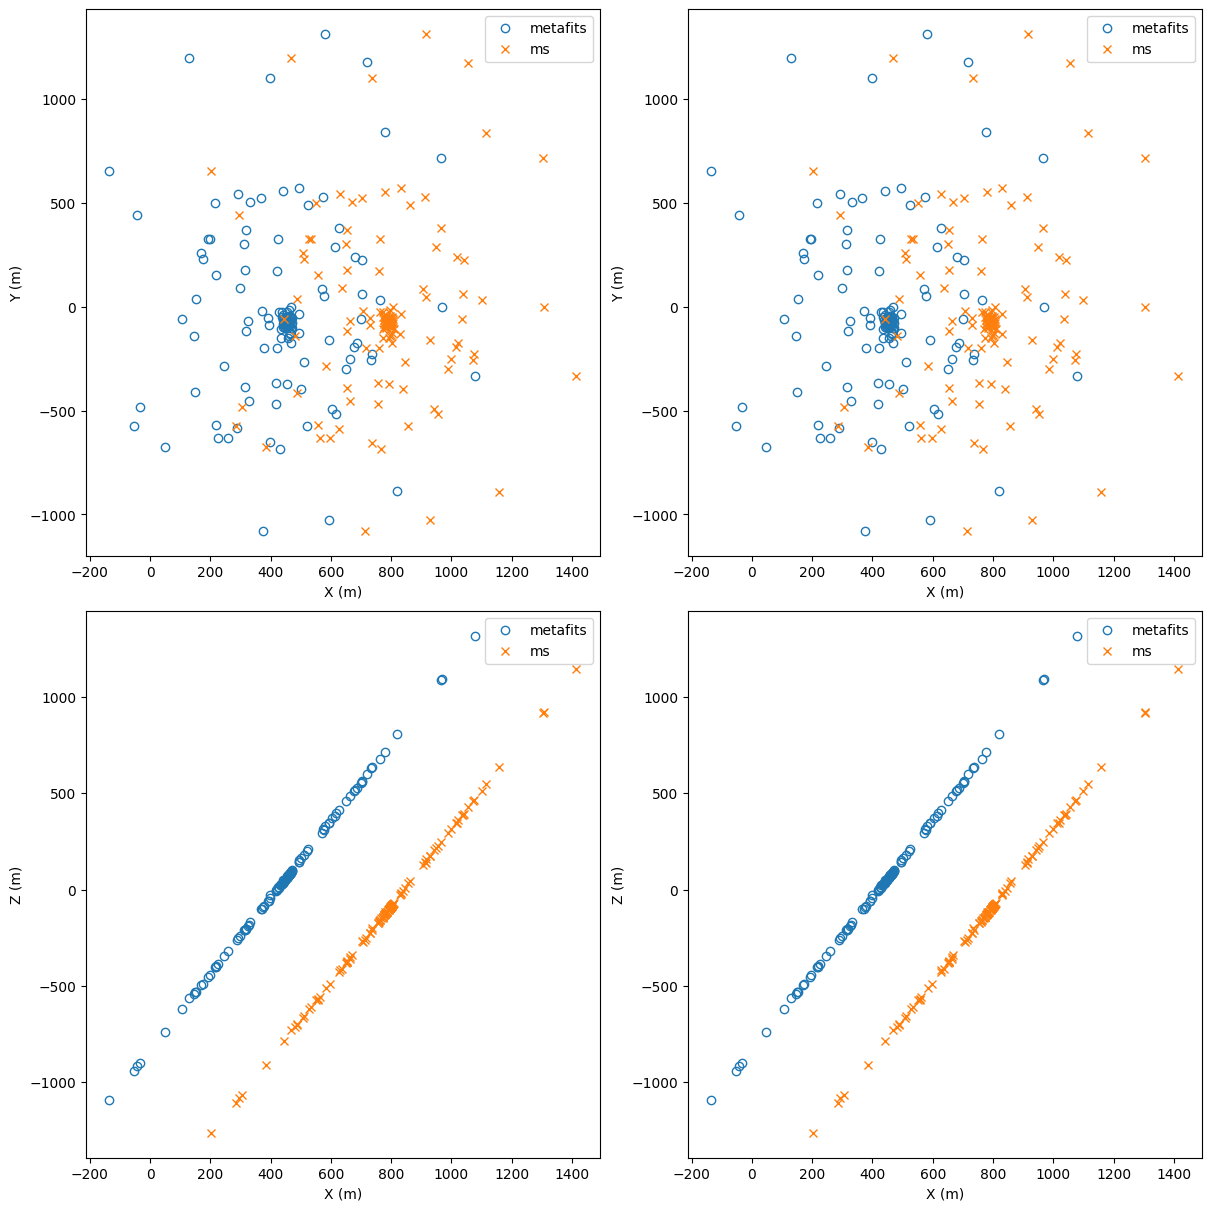

In [26]:
def plot(xyz, ax1, ax2, marker, label):
        
        ax1.plot(xyz[:,0], xyz[:,1], marker, mfc='none', label=label)
        ax2.plot(xyz[:,0], xyz[:,2], marker, mfc='none', label=label)
        
        
fig, axs = plt.subplots(2, 2, figsize=(12, 12), layout='constrained')

plot(xyz_meta, axs[0,0], axs[1,0], 'o', 'metafits')
plot(xyz_ms, axs[0,0], axs[1,0], 'x', 'ms')

plot(xyz_meta, axs[0,1], axs[1,1], 'o', 'metafits')
plot(xyz_ms, axs[0,1], axs[1,1], 'x', 'ms')

# axs[0,1].set_xlim(425, 500)
# axs[0,1].set_ylim(-200, 0)

# axs[1,1].set_xlim(430, 480)
# axs[1,1].set_ylim(0, 100)

for ax in axs.flatten():
    ax.legend()
    
axs[0,0].set_xlabel('X (m)')
axs[0,0].set_ylabel('Y (m)')
axs[0,1].set_xlabel('X (m)')
axs[0,1].set_ylabel('Y (m)')

axs[1,0].set_xlabel('X (m)')
axs[1,0].set_ylabel('Z (m)')
axs[1,1].set_xlabel('X (m)')
axs[1,1].set_ylabel('Z (m)')

plt.show()

Ah bummer there is some kind of central positional shift in the XYZs. Need to investigate that.

In [27]:
np.allclose(xyz_meta, xyz_ms, atol=1e-3, rtol=1e-6)


False

Now compare the `uv` coords. 

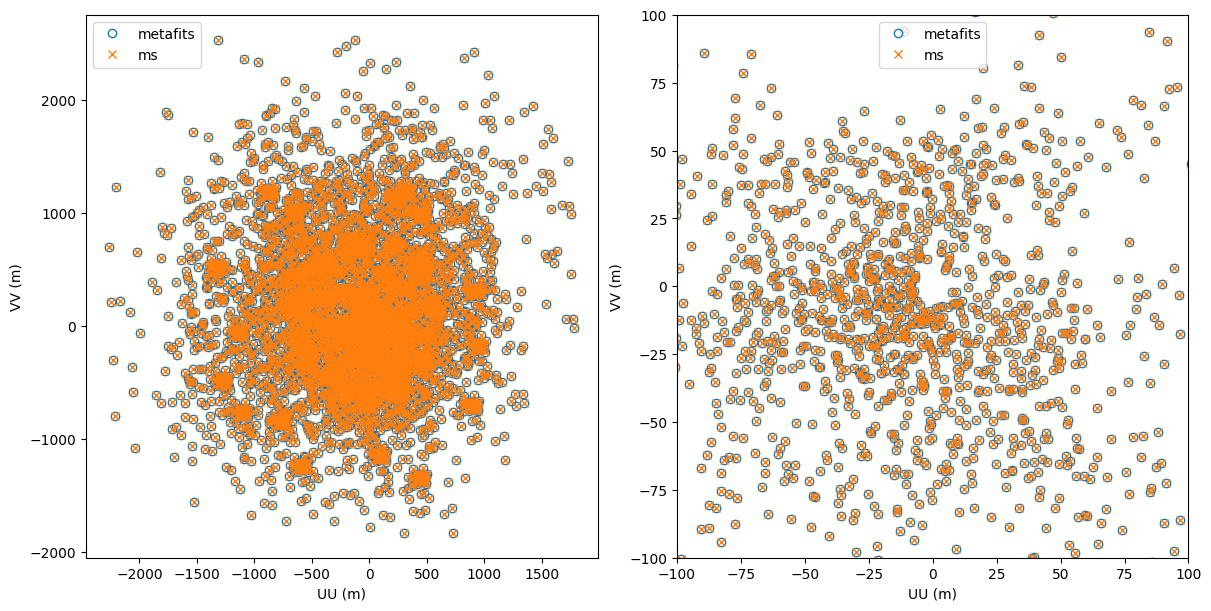

In [28]:
        
fig, axs = plt.subplots(1, 2, figsize=(12, 6), layout='constrained')


for ax in axs:

    ax.plot(uu_meta, vv_meta, 'C0o', mfc='none', label='metafits')
    # ax.plot(-uu_meta, -vv_meta, 'C0o', mfc='none')

    ax.plot(uu_ms, vv_ms, 'C1x', mfc='none', label='ms')
    # ax.plot(-uu_ms, -vv_ms, 'C1x', mfc='none')
    
    ax.set_xlabel('UU (m)')
    ax.set_ylabel('VV (m)')
    
    ax.legend()
        
axs[1].set_xlim(-100, 100)
axs[1].set_ylim(-100, 100)

plt.show()

In [29]:
print(f"u coords max, mean diff {np.max(np.abs(uu_meta - uu_ms)):.2e}, {np.mean(np.abs(uu_meta - uu_ms)):.2e} (metres)")
print(f"v coords max, mean diff {np.max(np.abs(vv_meta - vv_ms)):.2e}, {np.mean(np.abs(vv_meta - vv_ms)):.2e} (metres)")
print(f"w coords max, mean diff {np.max(np.abs(ww_meta - ww_ms)):.2e}, {np.mean(np.abs(ww_meta - ww_ms)):.2e} (metres)")

u coords max, mean diff 8.79e-03, 3.11e-04 (metres)
v coords max, mean diff 8.01e-03, 2.90e-04 (metres)
w coords max, mean diff 2.32e-03, 9.60e-05 (metres)


The layout might be shifted, but the it's pretty much indentical, as we end up with the same `uv` coordinates. So that's good.

## Try off zenith pointings

In [30]:

ra0 = 60.0
date = "2015-09-10T19:44:15"
observing_time = Time(date, scale='utc', location=mwa_location)

##Setup a grid of RA/Dec on the sky
nside=50
radec_reso = 120/nside

header, wcs = create_WCS(ra0, dec0, nside, radec_reso)
x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))
ras, decs = wcs.all_pix2world(x_mesh, y_mesh, 0)

ras = ras.flatten()
decs = decs.flatten()

num_comps = len(ras)

##Create the components struct
components = struct_classes.Components()
##Allocate memory for the coords
components.ras = (c_double*num_comps)()
components.decs = (c_double*num_comps)()

##populate the coords
for ind, ra, dec in zip(range(num_comps), np.radians(ras), np.radians(decs)):
    components.ras[ind] = ra
    components.decs[ind] = dec


##Do a single freqs and time and beam
all_freqs = np.array([100e+6, 200e+6])
all_times = np.array([observing_time, observing_time + TimeDelta(2*3600.0, format='sec')])
num_beams = 1
station_id = 0

lsts = []
latitudes = []

for obs_time in all_times:
    
    LST = obs_time.sidereal_time('mean')
    lst_current = np.radians(LST.value*15)
    
    lst_J2000, latitude_J2000 = RTS_Precess_LST_Lat_to_J2000(
                                lst_current,
                                np.radians(MWA_LAT),
                                obs_time.mjd)
    
    lsts.append(lst_J2000)
    latitudes.append(latitude_J2000)

##allocate memory for the beam values

num_freqs = len(all_freqs)
num_times = len(all_times)

complex_num_beams = c_double_complex*(num_comps*num_beams*num_freqs*num_times)
        
components.gxs = complex_num_beams()
components.Dxs = complex_num_beams()
components.Dys = complex_num_beams()
components.gys = complex_num_beams()

coeff_path="/home/jline/software/MWA_beam_files/mwa_full_embedded_element_pattern.h5"
ms_path = '/mnt/c/Users/jackl/Dropbox/work/test_WODEN/everybeam/run_MWA_beam/hypcal_1125949472.ms'
telescope = eb.load_telescope(ms_path, use_differential_beam=True,
                                  coeff_path=coeff_path)

calc_everybeam_for_components(np.radians(ra0), np.radians(station_id),
                              num_comps, components, telescope,
                              all_times, all_freqs,
                              station_id=station_id,
                              lsts=lsts, latitudes=latitudes,
                              parallactic_rotate=True)

In [31]:
##grab the outputs, which should be ordered as primary beam slowest changing, time, freq, componnent fastest changing
##Do it over loops so we can get the real/imag parts out of the c_double_complex struct
all_gx = np.zeros((num_beams, num_times, num_freqs, num_comps), dtype=np.complex128)
all_Dx = np.zeros((num_beams, num_times, num_freqs, num_comps), dtype=np.complex128)
all_Dy = np.zeros((num_beams, num_times, num_freqs, num_comps), dtype=np.complex128)
all_gy = np.zeros((num_beams, num_times, num_freqs, num_comps), dtype=np.complex128)

for beam_ind in range(num_beams):
    for time_ind, time in enumerate(all_times):
        for freq_ind, freq in enumerate(all_freqs):
            for comp_ind in range(num_comps):
                ind = beam_ind*num_comps*num_freqs*num_times + time_ind*num_comps*num_freqs + freq_ind*num_comps + comp_ind
                # beam_ind*num_comps*num_freqs*num_times + time_ind*num_comps*num_freqs + freq_ind*num_comps + comp_ind
                
                all_gx[beam_ind, time_ind, freq_ind, comp_ind] = components.gxs[ind].real + 1j*components.gxs[ind].imag
                all_Dx[beam_ind, time_ind, freq_ind, comp_ind] = components.Dxs[ind].real + 1j*components.Dxs[ind].imag
                all_Dy[beam_ind, time_ind, freq_ind, comp_ind] = components.Dys[ind].real + 1j*components.Dys[ind].imag
                all_gy[beam_ind, time_ind, freq_ind, comp_ind] = components.gys[ind].real + 1j*components.gys[ind].imag

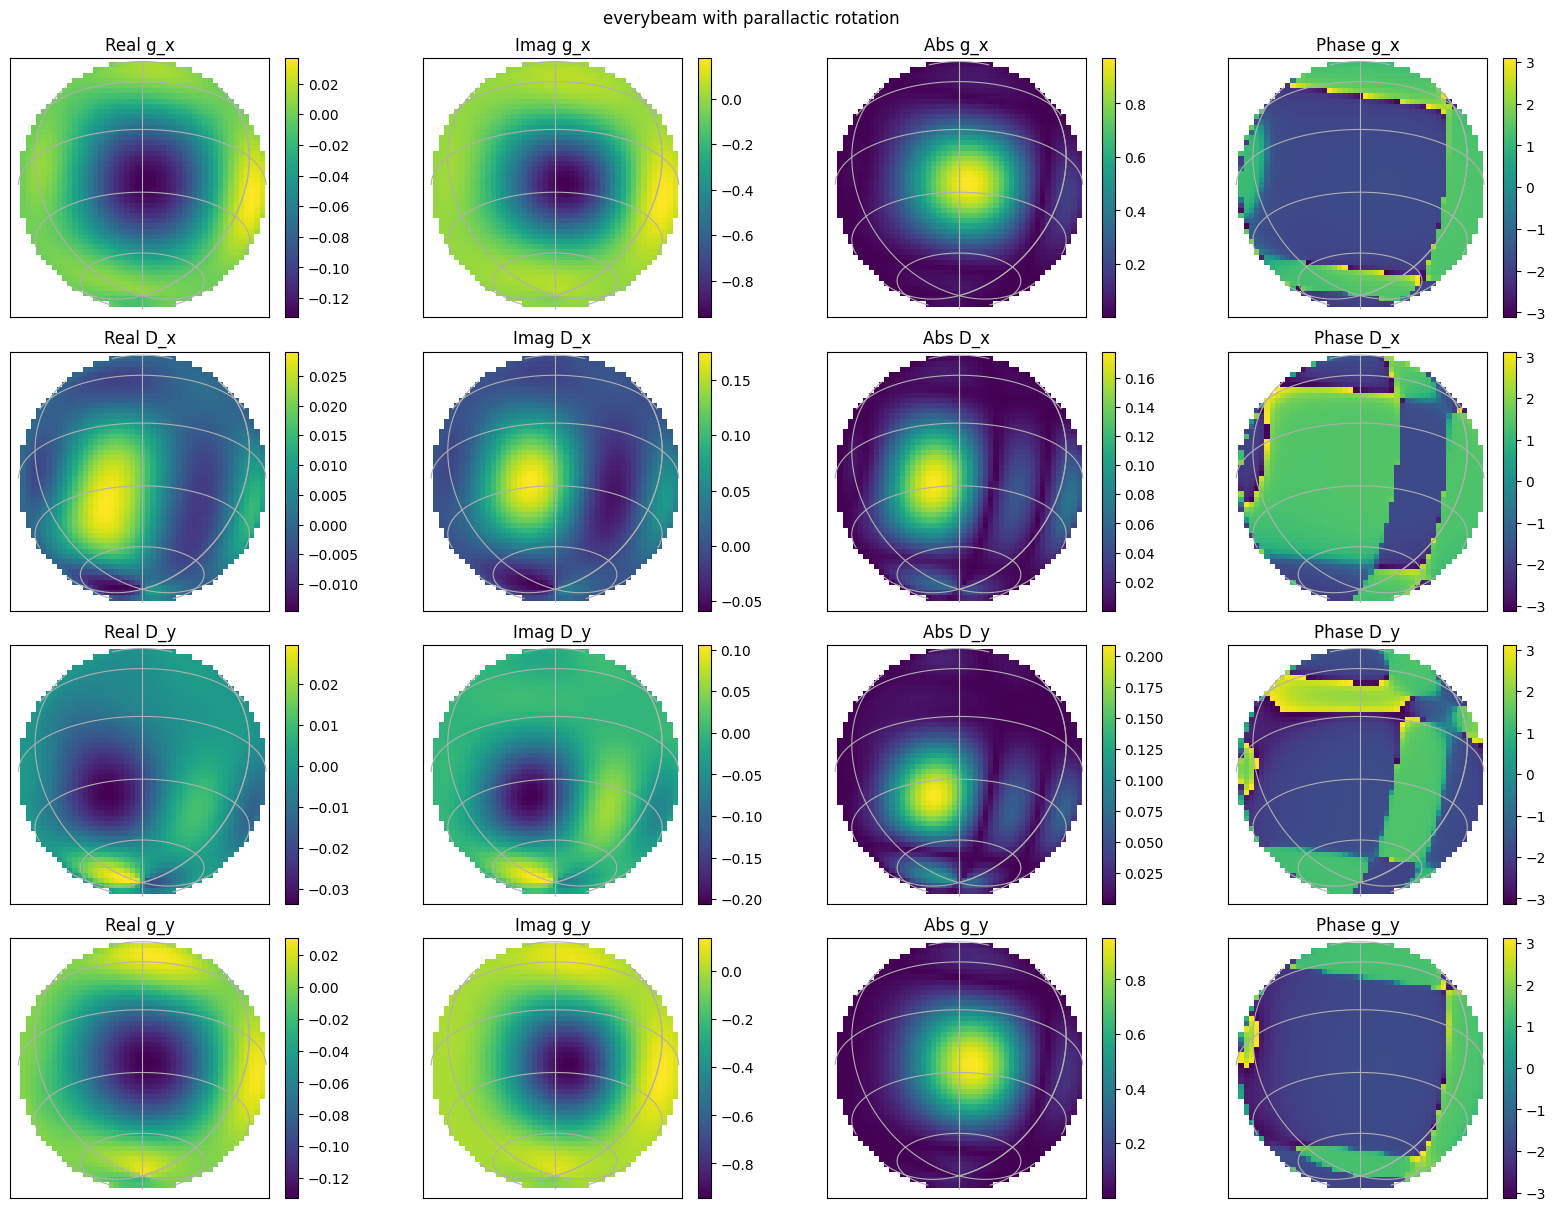

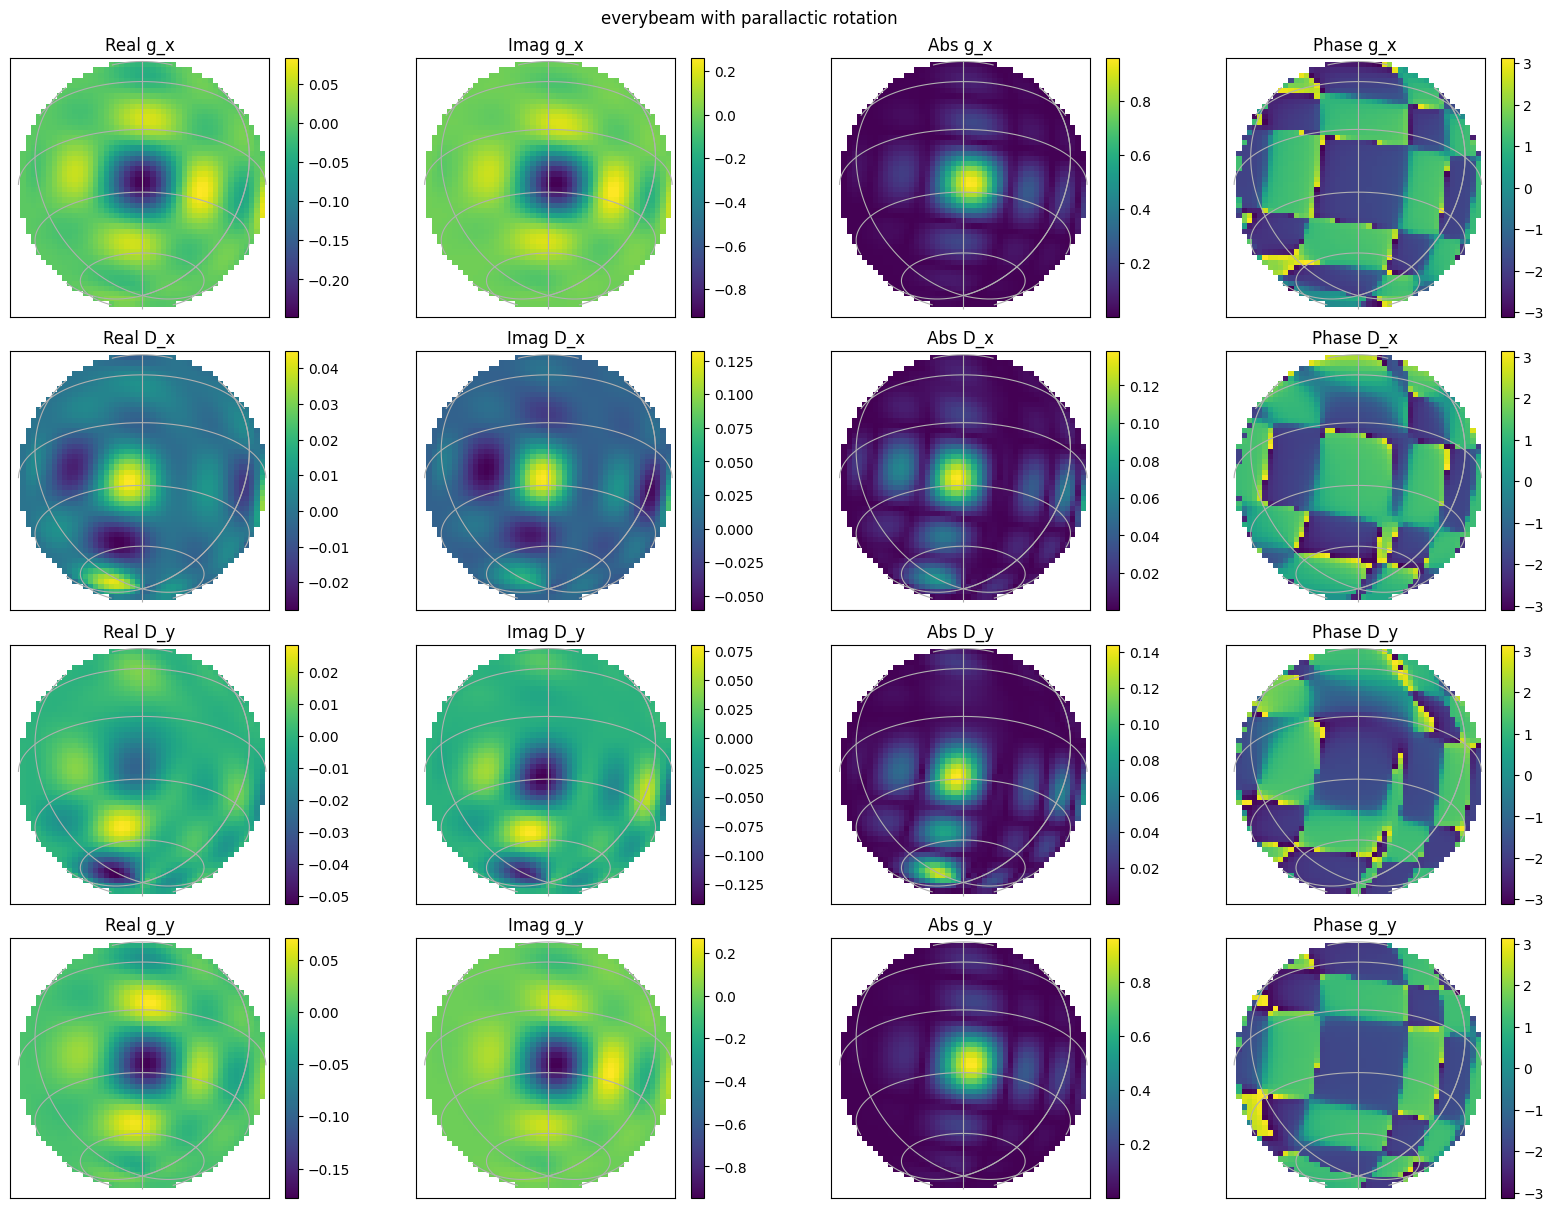

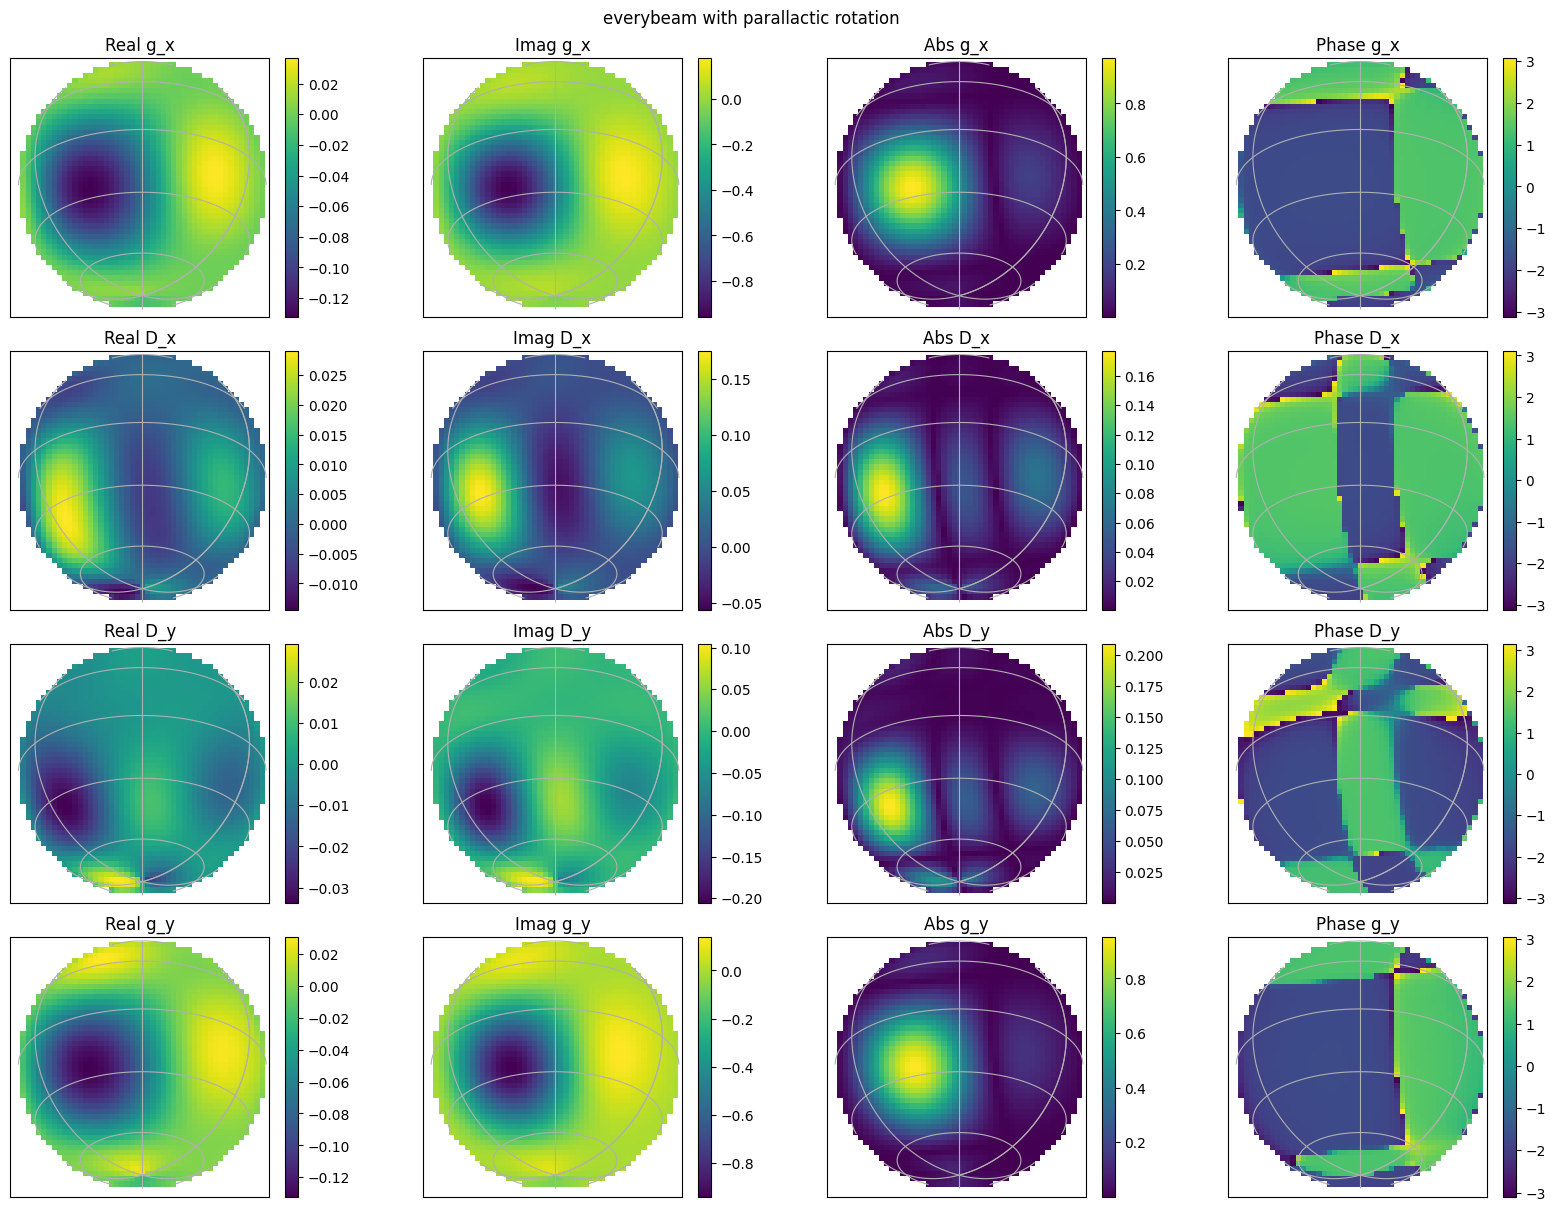

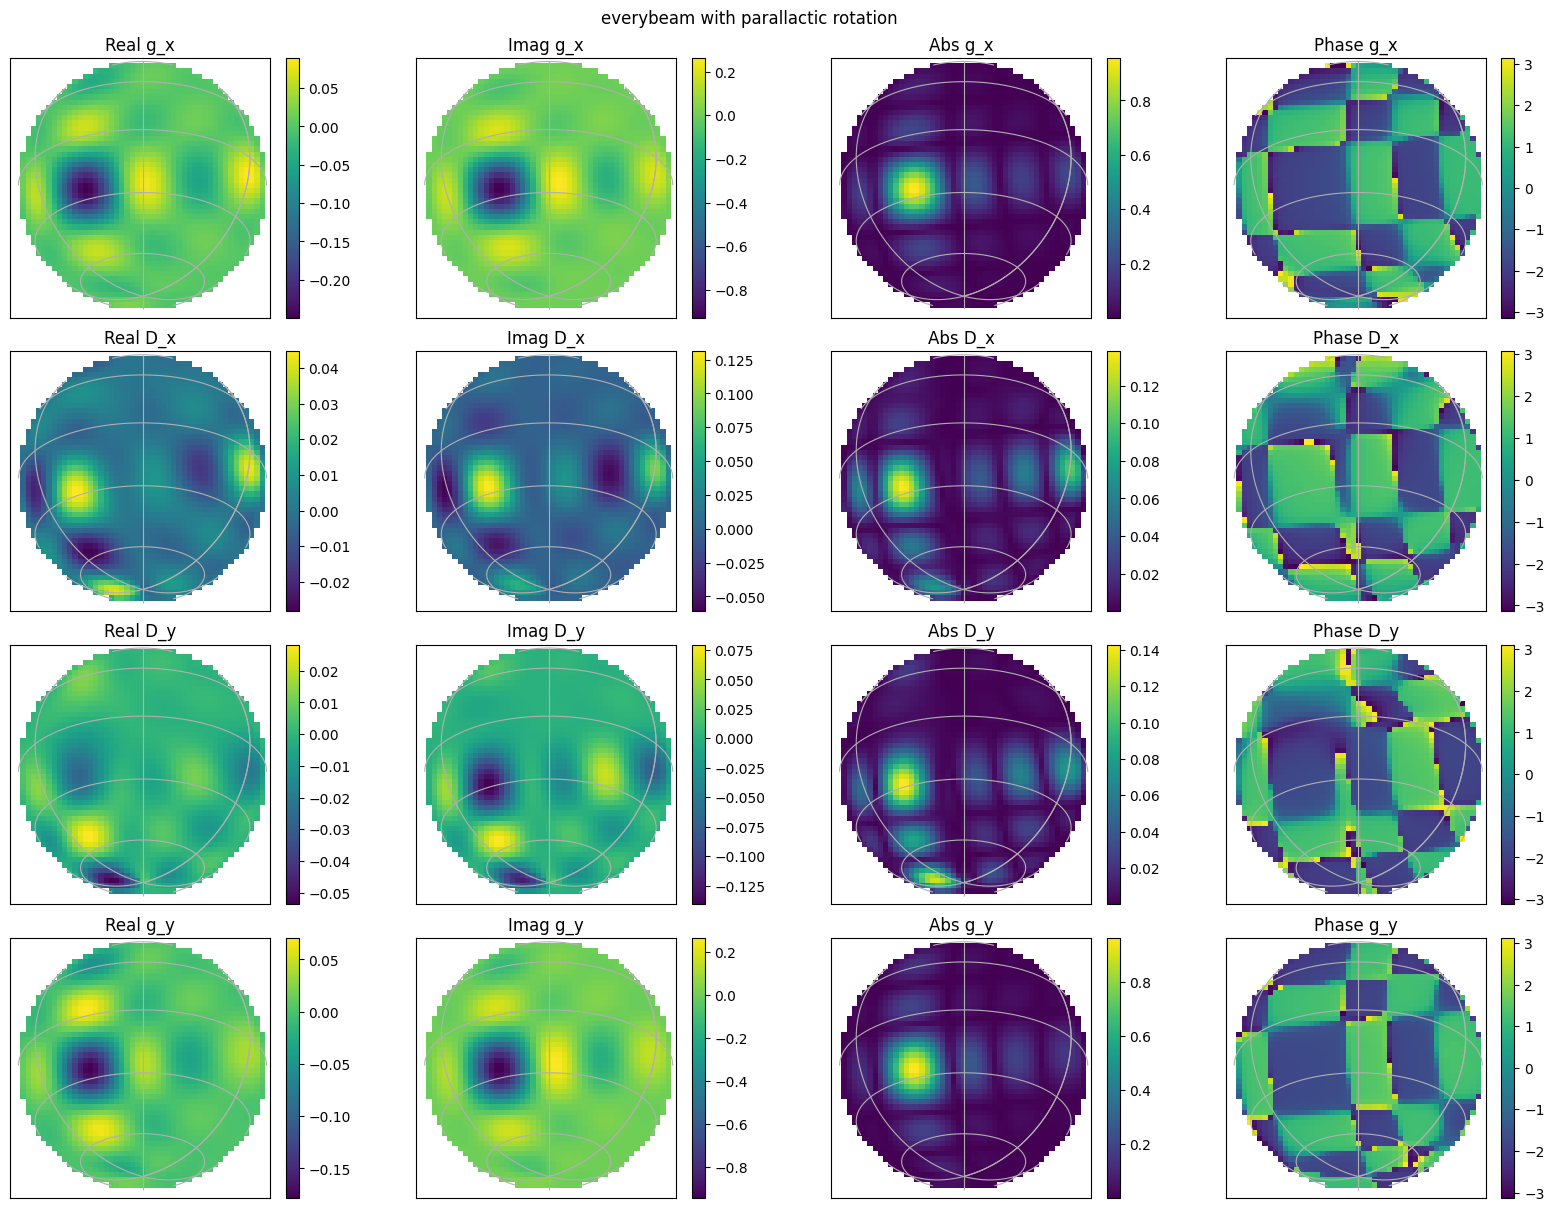

In [32]:
for time_ind in range(len(all_times)):
    for freq_ind in range(len(all_freqs)):
        this_gx = all_gx[0, time_ind, freq_ind, :]
        this_Dx = all_Dx[0, time_ind, freq_ind, :]
        this_Dy = all_Dy[0, time_ind, freq_ind, :]
        this_gy = all_gy[0, time_ind, freq_ind, :]
        
        this_gx.shape = (nside, nside)
        this_Dx.shape = (nside, nside)
        this_Dy.shape = (nside, nside)
        this_gy.shape = (nside, nside)

        plot_jones_on_sky(this_gx, this_Dx, this_Dy, this_gy, wcs, title="everybeam with parallactic rotation")

should look like

/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:18110: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


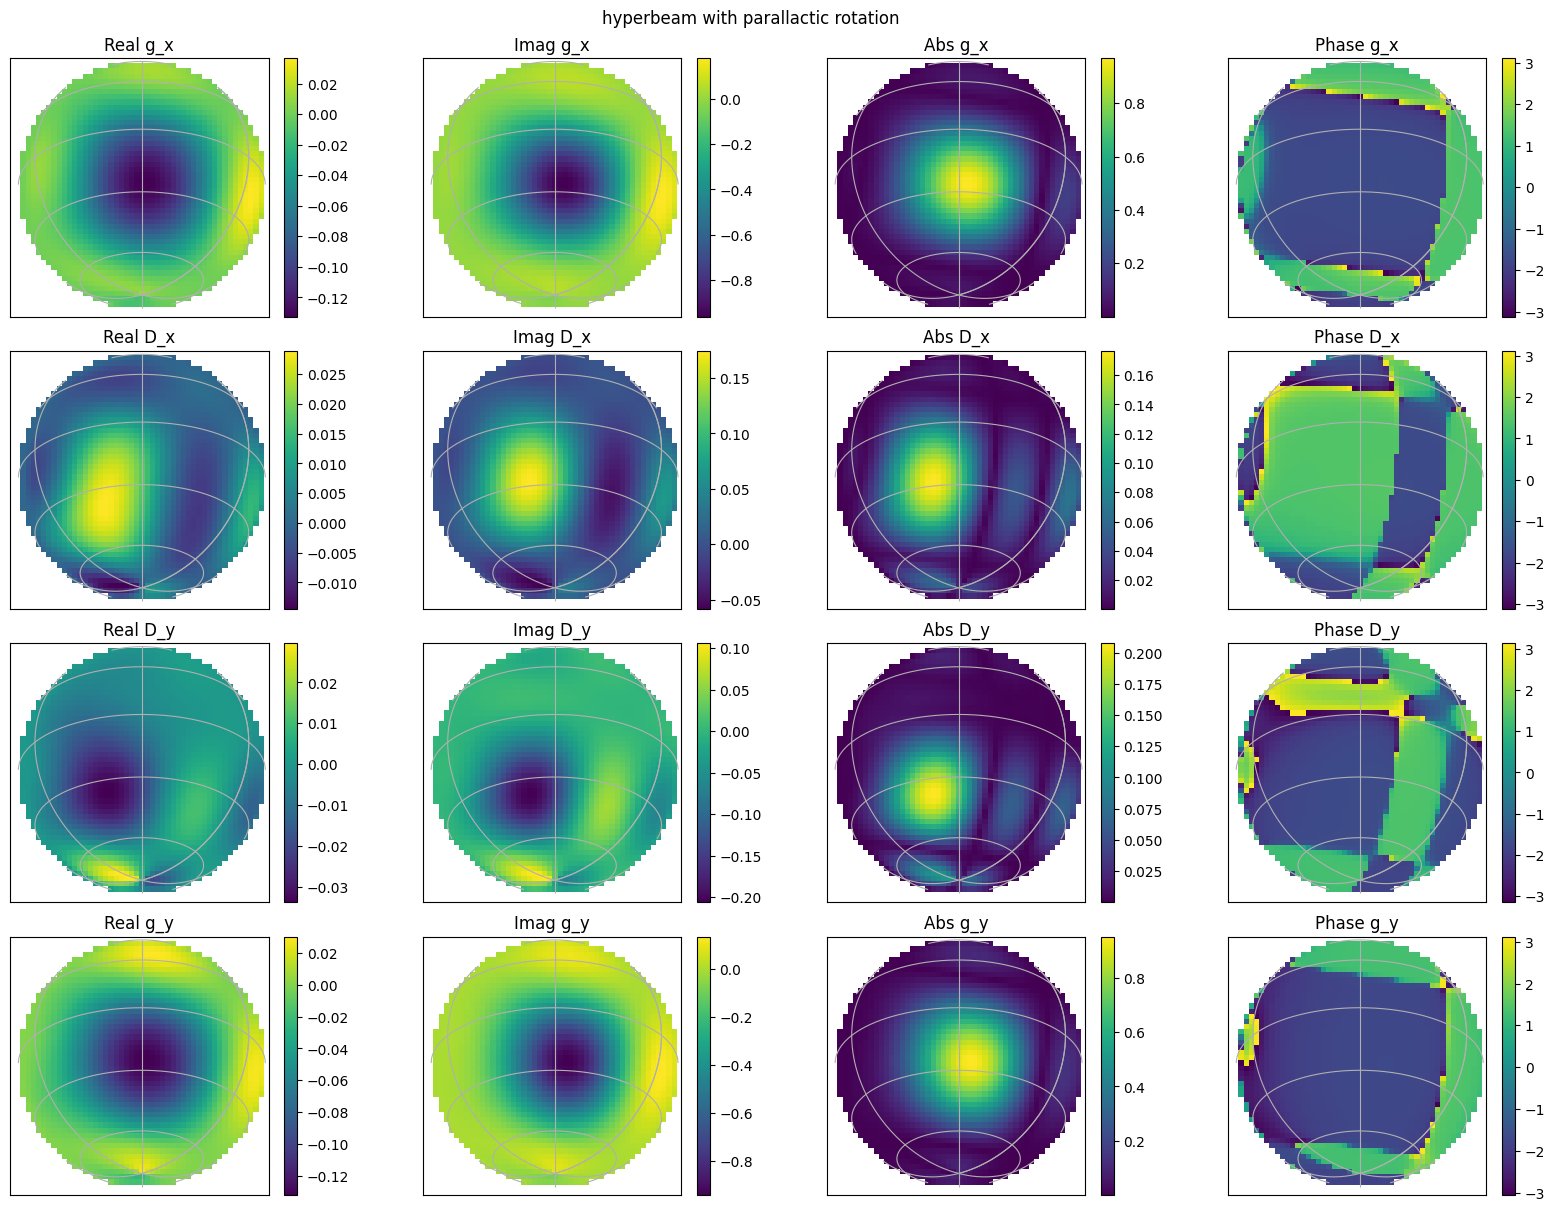

/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:18110: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


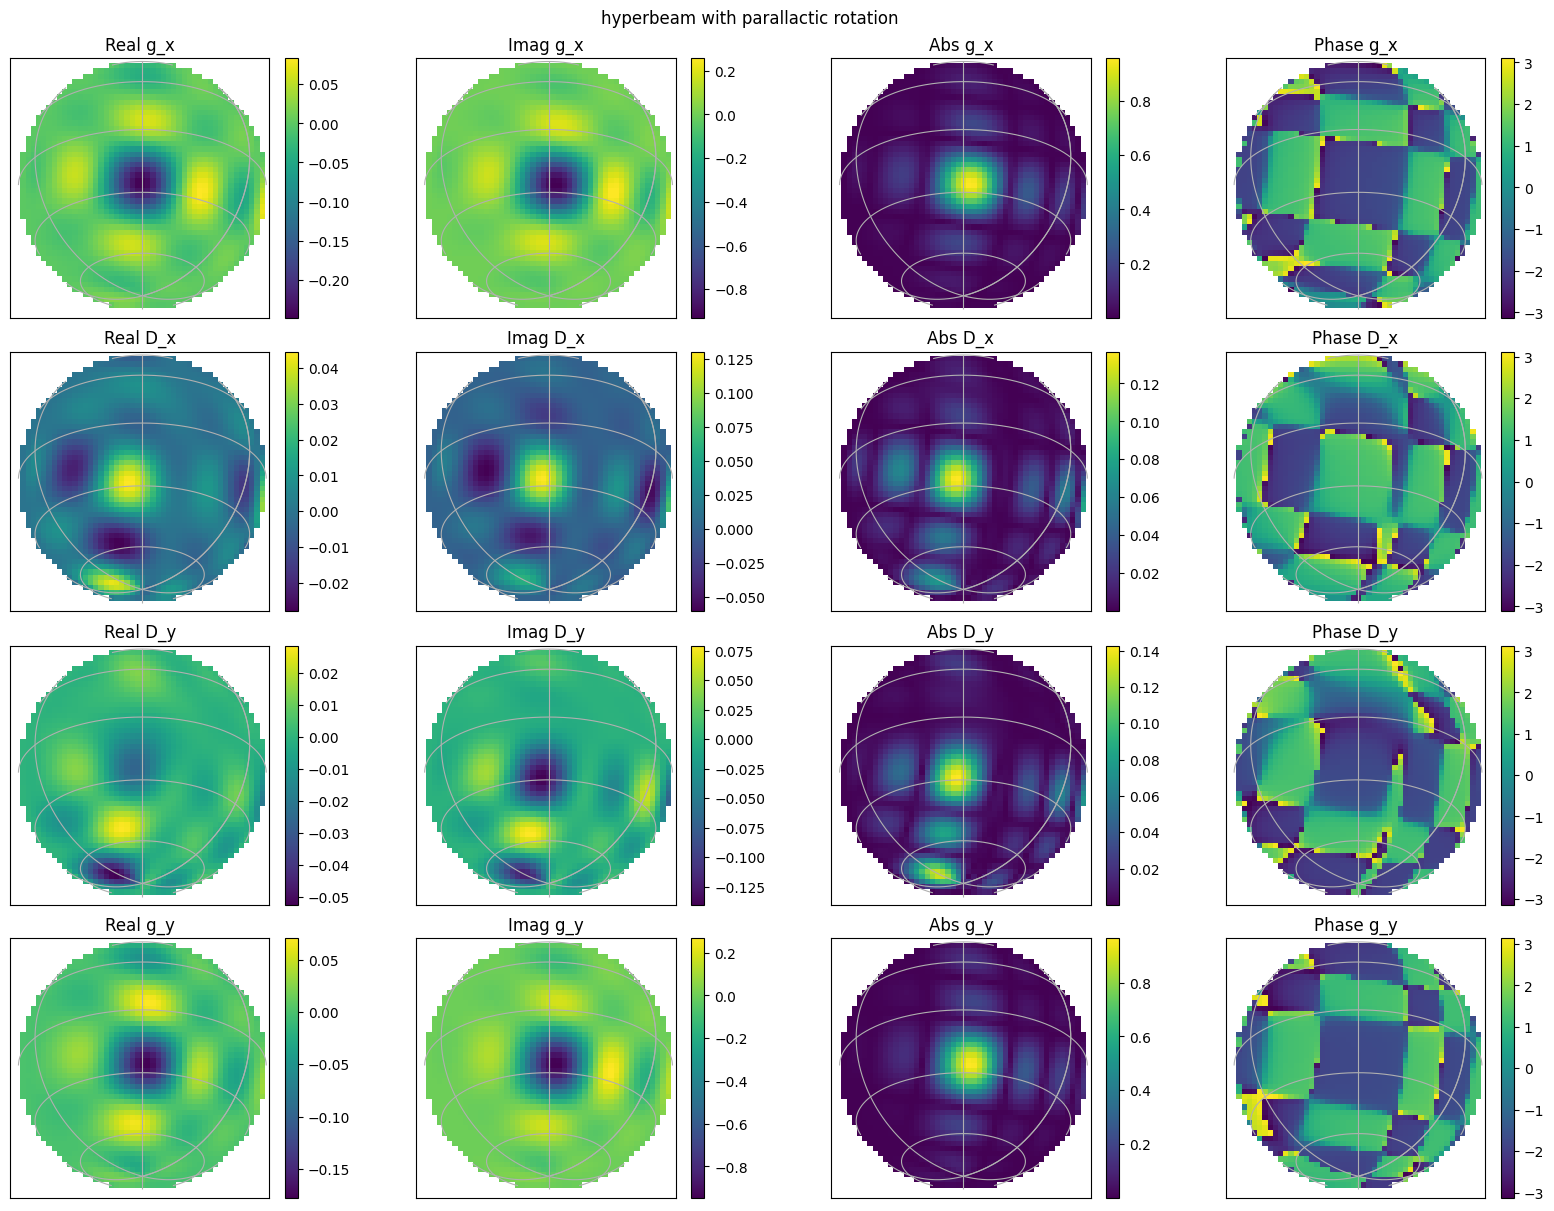

/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:18110: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


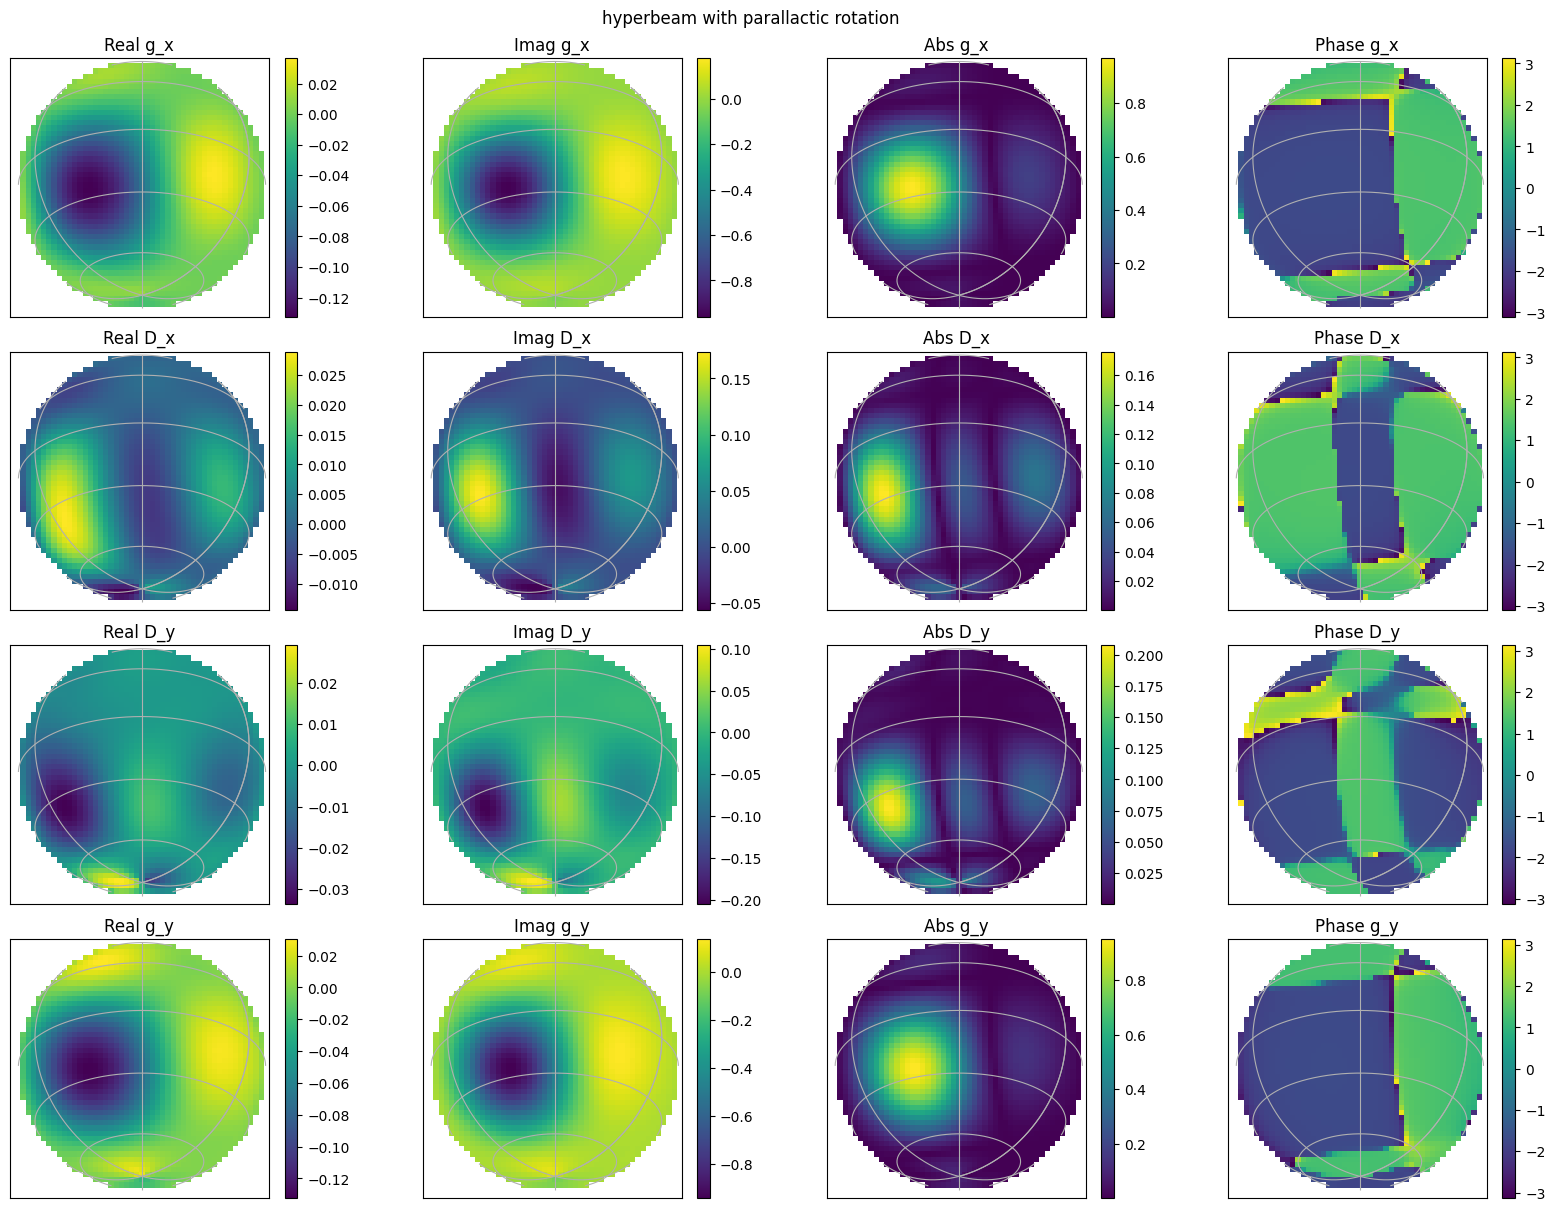

/home/jline/software/anaconda3/envs/woden_dev/lib/python3.12/site-packages/erfa/core.py:18110: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


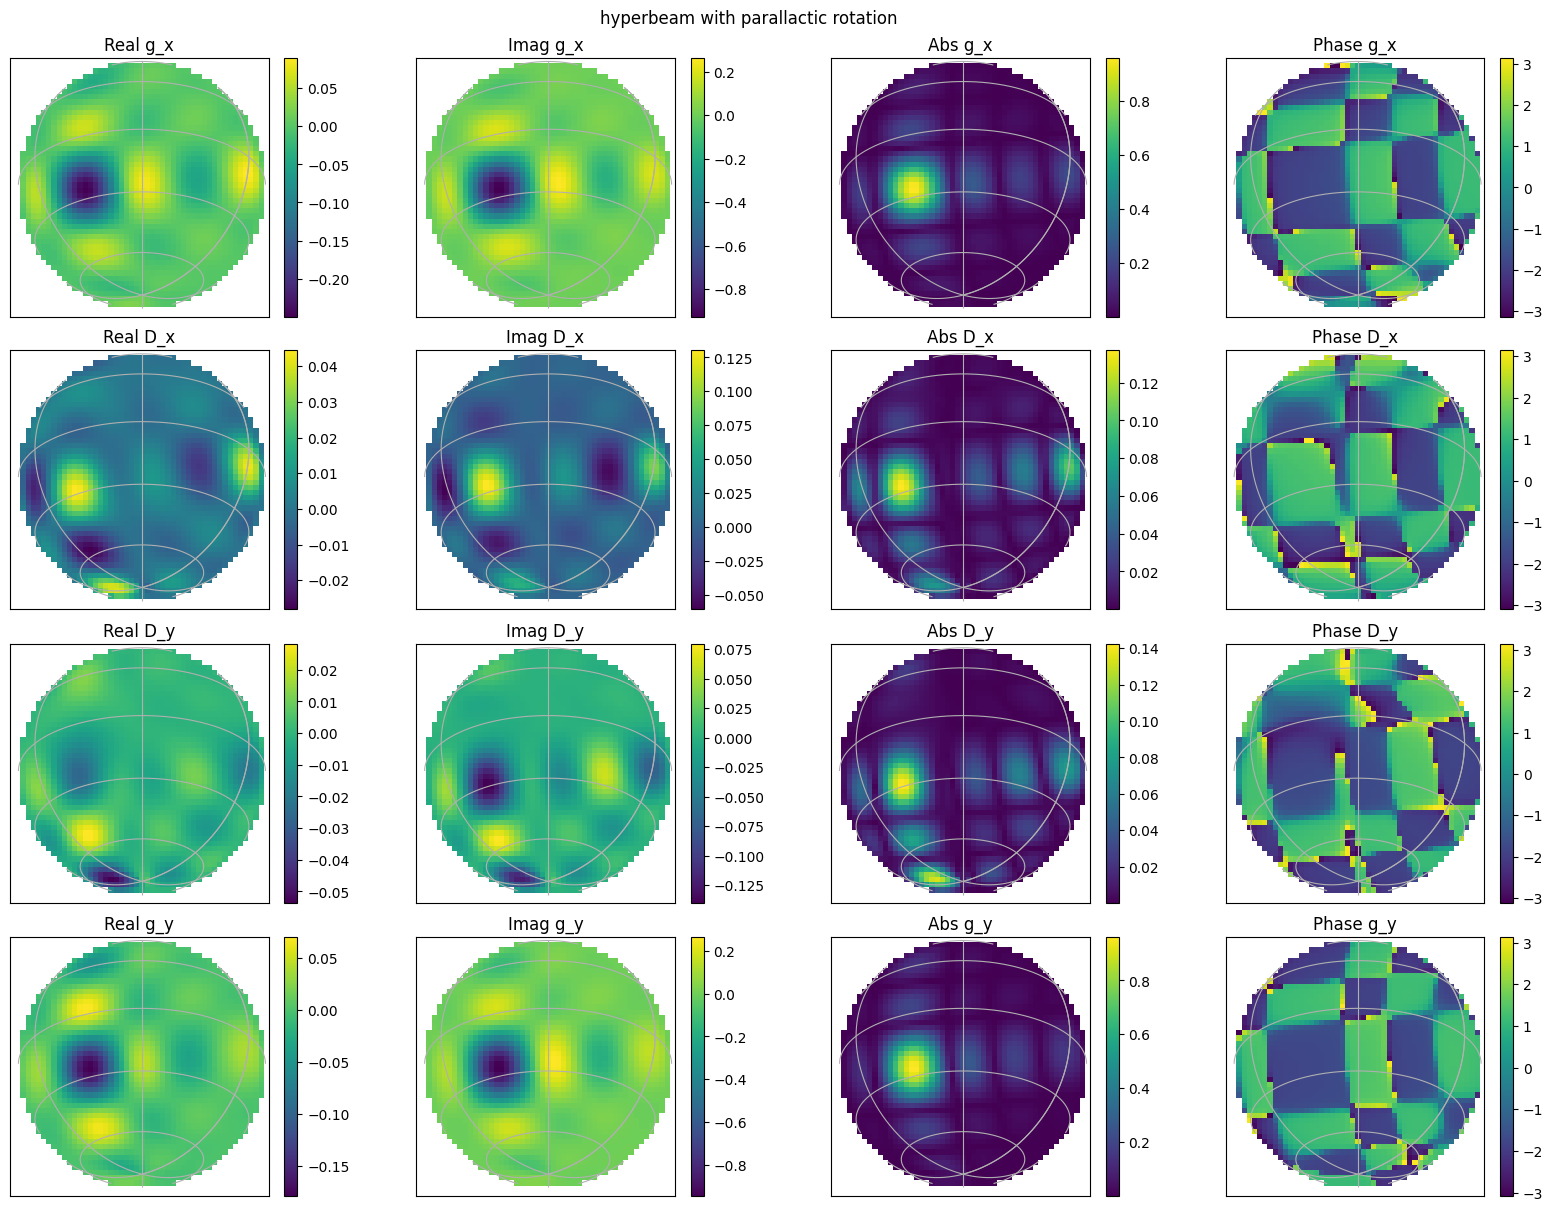

In [33]:
##use this erfa function to convert to azimuth and elevation
##were using degrees, but erfa uses rads, so convert here

for this_time in all_times:
    for freq in all_freqs:

        has = this_time.sidereal_time('mean').value*15.0 - ras

        az_grid, els = erfa.hd2ae(np.radians(has), np.radians(decs), np.radians(MWA_LAT))

        za_grid = np.pi/2 - els

        beam = mwa_hyperbeam.FEEBeam()

        parallactic_rotation = True
        delays = [0,2,4,6,0,2,4,6,0,2,4,6,0,2,4,6]

        jones = beam.calc_jones_array(az_grid, za_grid, freq, delays, [1]*16, True, np.radians(MWA_LAT), parallactic_rotation)

        all_gx = jones[:,0]
        all_Dx = jones[:,1]
        all_Dy = jones[:,2]
        all_gy = jones[:,3]

        all_gx.shape = (nside, nside)
        all_Dx.shape = (nside, nside)
        all_Dy.shape = (nside, nside)
        all_gy.shape = (nside, nside)

        plot_jones_on_sky(all_gx, all_Dx, all_Dy, all_gy, wcs, title="hyperbeam with parallactic rotation")

## Profiling the code

Here we'll profile the code to see where the bottlenecks are. We'll use `yappi` as it can do threads, which `run_woden.py` uses. First up, load `run_woden.py` as a module, so we can call the `main` function.

In [35]:
import yappi

Now make a sky model with an array of ra, decs.

In [44]:
nside=15
radec_reso = 30/nside

ra0 = 0

header, wcs = create_WCS(ra0, dec0, nside, radec_reso)
x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))
ras, decs = wcs.all_pix2world(x_mesh, y_mesh, 0)

ras = ras.flatten()
decs = decs.flatten()

num_comps = len(ras)

c_ids = Column(data=np.array(['source']*num_comps), name='UNQ_SOURCE_ID', dtype='|S20')
c_names = Column(data=np.array([f'source_C{i:04d}' for i in range(num_comps)]), name='NAME', dtype='|S20')

##Component position
c_ras = Column(data=ras, name='RA')
c_decs = Column(data=decs, name='DEC')

##This says we have a point source
c_comp_types = Column(data=np.array(['P']*num_comps, dtype='|S1'), name="COMP_TYPE", dtype='|S1')
##This says we have a Stokes I power-law SED
c_mod_types = Column(data=np.array(['pl']*num_comps, dtype='|S3'), name="MOD_TYPE", dtype='|S3')

##Set everything as a flat spectrum 1 Jy stokes I source. That way we can image it and see the beam pattern
c_stokes_I_ref = Column(data=np.ones(num_comps), name='NORM_COMP_PL')
c_stokes_I_SI = Column(data=np.zeros(num_comps), name='ALPHA_PL')


cols = [c_ids, c_names, c_ras, c_decs, c_comp_types, c_mod_types, c_stokes_I_ref, c_stokes_I_SI]

main_table = Table(cols)

profile_cat = 'profiling_source.fits'

main_table.write(profile_cat, format='fits', overwrite=True)

This may seem counter intuitive, but we'll run the profiler code via the command line (in a script called `run_woden_profiled.py`). This is because the notebook seems to whack in 15 million extra threads which is a pain. I've copy and pasted the contents here so you can see what's going on

```python
#!/usr/bin/env python3
"""Wrapper script to profile WODEN code.
"""
import sys
import yappi

##Import the run_woden.py script as a mdoule
sys.path.append('../../scripts')
import run_woden as rw


if __name__ == "__main__":

    ##set up some arguments
    num_times = 4
    num_freqs = 4
    
    ra0 = 0.0
    dec0 = -26.7
    date = "2024-07-21T20:13:00"
    profile_cat = "profiling_source.fits"

    args = []
    args.append("--band_nums=1")
    args.append("--lowest_channel_freq=160e+6")
    args.append(f"--num_freq_channels={num_freqs}")
    args.append("--freq_res=80e+3")
    args.append(f"--num_time_steps={num_times}")
    args.append("--time_res=2")
    args.append(f"--ra0={ra0}")
    args.append(f"--dec0={dec0}")
    args.append(f"--date={date}")
    args.append(f"--station_id=0")
    args.append(f"--cat_filename={profile_cat}")
    args.append("--output_uvfits_prepend=profile_run_woden")
    args.append(f'--beam_ms_path=MWA-single-timeslot.ms')
    args.append("--primary_beam=everybeam_MWA")
    
    yappi.set_clock_type("wall") # Use set_clock_type("cpu") for CPU time

    with yappi.run():
        ##Run the actual WODEN code, using the args we set up
        rw.main(args)

    yappi.stop()

    ##This prints out everything that was called in the `wodenpy` module
    print('\nWODENPY MODULE STATS------------------------------------------------------------')
    stats = yappi.get_func_stats(filter_callback=lambda x: 'wodenpy' in x.module
                                ).print_all()
    print('--------------------------------------------------------------------------------\n')


    print('\nGPU CALL THREAD-----------------------------------------------------------------')
    threads = yappi.get_thread_stats()
    ##Second thread calls the GPU code. Search within that for the function called
    ##`_run_run_woden`, which is calling the C/GPU code
    stats = yappi.get_func_stats(ctx_id=2,
                                    filter_callback=lambda x: '_run_run_woden' in x.name
                                ).print_all()
    
    print('--------------------------------------------------------------------------------\n')
```

Run that on the command line via

```bash	
python run_woden_profiled.py
```

I can't do it in the notebook because my `everybeam` python module is referenced via my `PYTHONPATH`, which I cannot for the life of my get to work in the notebook. A cropped version of the output is below:

which is saying that calling `run_everybeam` in total takes ~240 seconds. The second longest `wodenpy` function is `get_uvfits_date_and_position_constants` which takes ~2.0 seconds. The entire C/GPU code takes 0.3 seconds. So the `everybeam` code is the bottleneck, which is expected as it's doing the beam forming, in serial, on the CPU.

We can also sanity check that our GPU is truly only taking 0.3 by using `nvprof` to do a CUDA profile on this Python profiling code (how meta). This command is very specifically for my machine, as I have an NVIDIA GPU, with access to `nvprof` on the command line.

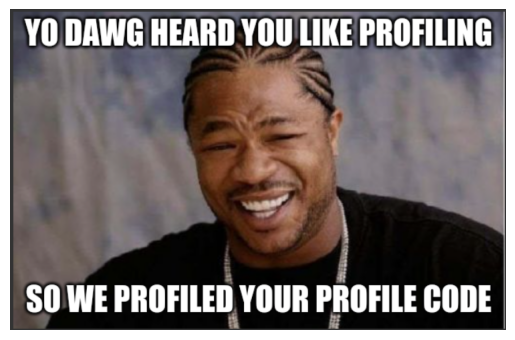

In [38]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('yo_dawg.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

Run this on the command line via
```bash
nvprof --openacc-profiling off python run_woden_profiled.py
```

If we look at part of the outputs here:
```
==1446872== Profiling application: python run_woden_profiled.py
==1446872== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   85.05%  21.031ms         1  21.031ms  21.031ms  21.031ms  kern_calc_visi_point_or_gauss(_components_t, _d_beam_gains_t, double*, double*, double*, double*, double*, double*, double*, double*, double*, double*, double*, int, int, int, int, int, e_beamtype, e_component_type)
                    7.67%  1.8972ms        24  79.048us     352ns  158.98us  [CUDA memcpy HtoD]
                    7.05%  1.7426ms        11  158.42us  158.24us  158.63us  [CUDA memcpy DtoH]
```

we see the top three GPU calls sum up to of order ~0.3s so we really are capturing the GPU time during the `yappi` profiling. 

In [45]:
cmd = "woden_uv2ms.py "
cmd += "  --uvfits_prepend=profile_run_woden_band "
cmd += "  --band_nums=1  "

call(cmd, shell=True)

cmd = "wsclean -name profile_run_woden -size 2048 2048 -niter 10000 "
cmd += "  -auto-threshold 0.5 -auto-mask 3 "
cmd += "  -pol I -multiscale -weight briggs 0 -scale 0.03 -j 12 -mgain 0.85 "
cmd += "  -no-update-model-required "
cmd += "  profile_run_woden_band*.ms "

print(cmd)

# call(cmd, shell=True)

/home/jline/software/anaconda3/envs/woden_dev/bin/woden_uv2ms.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.3.0')
The telescope frame is set to '????', which generally indicates ignorance. Defaulting the frame to 'itrs', but this may lead to other warnings or errors.
Writing in the MS file that the units of the data are uncalib, although some CASA process will ignore this and assume the units are all in Jy (or may not know how to handle data in these units).


wsclean -name profile_run_woden -size 2048 2048 -niter 10000   -auto-threshold 0.5 -auto-mask 3   -pol I -multiscale -weight briggs 0 -scale 0.03 -j 12 -mgain 0.85   -no-update-model-required   profile_run_woden_band*.ms 


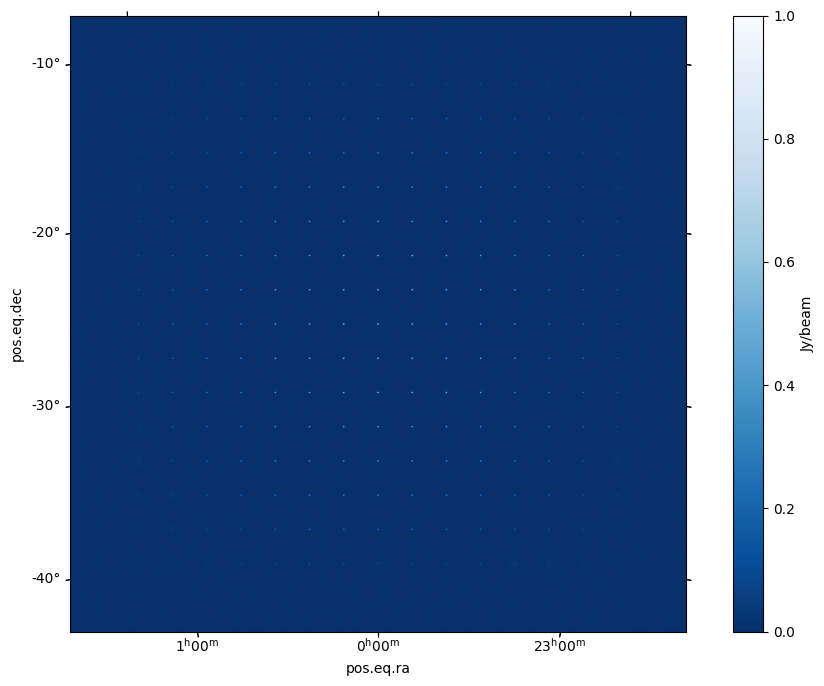

In [46]:

with fits.open('profile_run_woden-image.fits') as hdu:
    image = np.squeeze(hdu[0].data)
    wcs = WCS(hdu[0].header).celestial
    
fig, axs = plt.subplots(1, 1, figsize=(12, 8), subplot_kw={'projection': wcs})

im = axs.imshow(image, origin='lower', cmap='Blues_r', vmin=0, vmax=1.0)
plt.colorbar(im, ax=axs, label='Jy/beam')

half_width = 600

axs.set_xlim(1024-half_width, 1024+half_width)
axs.set_ylim(1024-half_width, 1024+half_width)

plt.show()

Looks like the point sources toward the edge are being tapered off ala a good old MWA primary beam lobe, so huzzah.